# Experimentación - ASTGCN


https://ojs.aaai.org/index.php/AAAI/article/view/3881

## 1. Obtención de datos



In [1]:
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload  # Python 3.4+


import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))


from utils import powergrid

In [2]:
#folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"
folder_path = "/Users/maguado/Documents/UGR/Master/TFM/datos_2/Natural Oscillation"

In [3]:
results_save_path = "./results"
name_model = "ASTGCN"

In [4]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="regression")
_,_,_ =loader.process()
limit = 300
#dataset_full = loader.get_dataset( target= 20, intro=300, step=20, limit=limit, one_ts_per_situation=False)

Processing dataset...
Processing:  row_307
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_135
Processing:  row_75
Processing:  row_338
Processing:  row_81
Processing:

## Funciones auxiliares - entrenamiento

In [5]:
from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable


import torch
import torch.nn.functional as F
from utils.utils_graph import format_plot
from utils.utils_graph import plot_training_and_eval_losses, plot_predictions
from utils.general_nn import guardar_resultados

from utils.astgcn import ASTGCN

from utils.trainer import TrainerMSTGCN
from utils.models import ASTGCNModel


## Prueba - predicción por tipos

In [6]:
dataloader_params2 = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True,
            "use_batch":False
}

device = torch.device("cpu")
num_early_stop = 10
num_epochs = 100
lr = 0.01

### Gen trip

In [7]:
problem_gt = "gen_trip"
dataset_gt, situations_gt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_gt)



Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  184


In [8]:
n_div_gt = loader.div
n_nodes =dataset_gt.features[0].shape[0]
n_target = dataset_gt.targets[0].shape[1]
n_features = dataset_gt[0].x.shape[1]
hidden_size =100



#### Sencilla 

In [9]:
from importlib import reload
import utils.models
utils.models = reload(utils.models)
from utils.models import ASTGCNModel

In [12]:
device =  torch.device("cpu")
model_gt = ASTGCNModel(name="MSTGCN", node_features=n_features, node_count=n_nodes, n_target=n_target, nb_block=1, k=2, nb_chev_filter = 3, nb_time_filter =3, time_strides = 2, hidden_size=100)

trainer_gt = TrainerMSTGCN(model_gt, dataset_gt,device, f"./results/{problem_gt}", dataloader_params2)


losses,eval_losses, r2scores  = trainer_gt.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)





==================== DATASET INFO ===================

Train dataset: 4352
Validation dataset: 918
Test dataset: 952

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0.1596 | Eval Loss: 0.0417 | Eval R2: -12.9348 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 0.0344 | Eval Loss: 0.0246 | Eval R2: -7.2086 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 0.0224 | Eval Loss: 0.0184 | Eval R2: -4.7004 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 0.0179 | Eval Loss: 0.0161 | Eval R2: -3.8279 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 0.0160 | Eval Loss: 0.0149 | Eval R2: -3.4298 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 0.0148 | Eval Loss: 0.0141 | Eval R2: -3.1719 | LR: 0.0010 | 
Epoch 7/100 | Train Loss: 0.0140 | Eval Loss: 0.0134 | Eval R2: -2.9753 | LR: 0.0010 | 
Epoch 8/100 | Train Loss: 0.0133 | Eval Loss: 0.0130 | Eval R2: -2.8185 | LR: 0.0010 | 
Epoch 9/100 | Train Loss: 0.0128 | Eval Loss: 0.0126 | Eval R2: -2.6932 | LR: 0.0010 | 
Epoch 10/100 | Train Loss: 0.0123 |

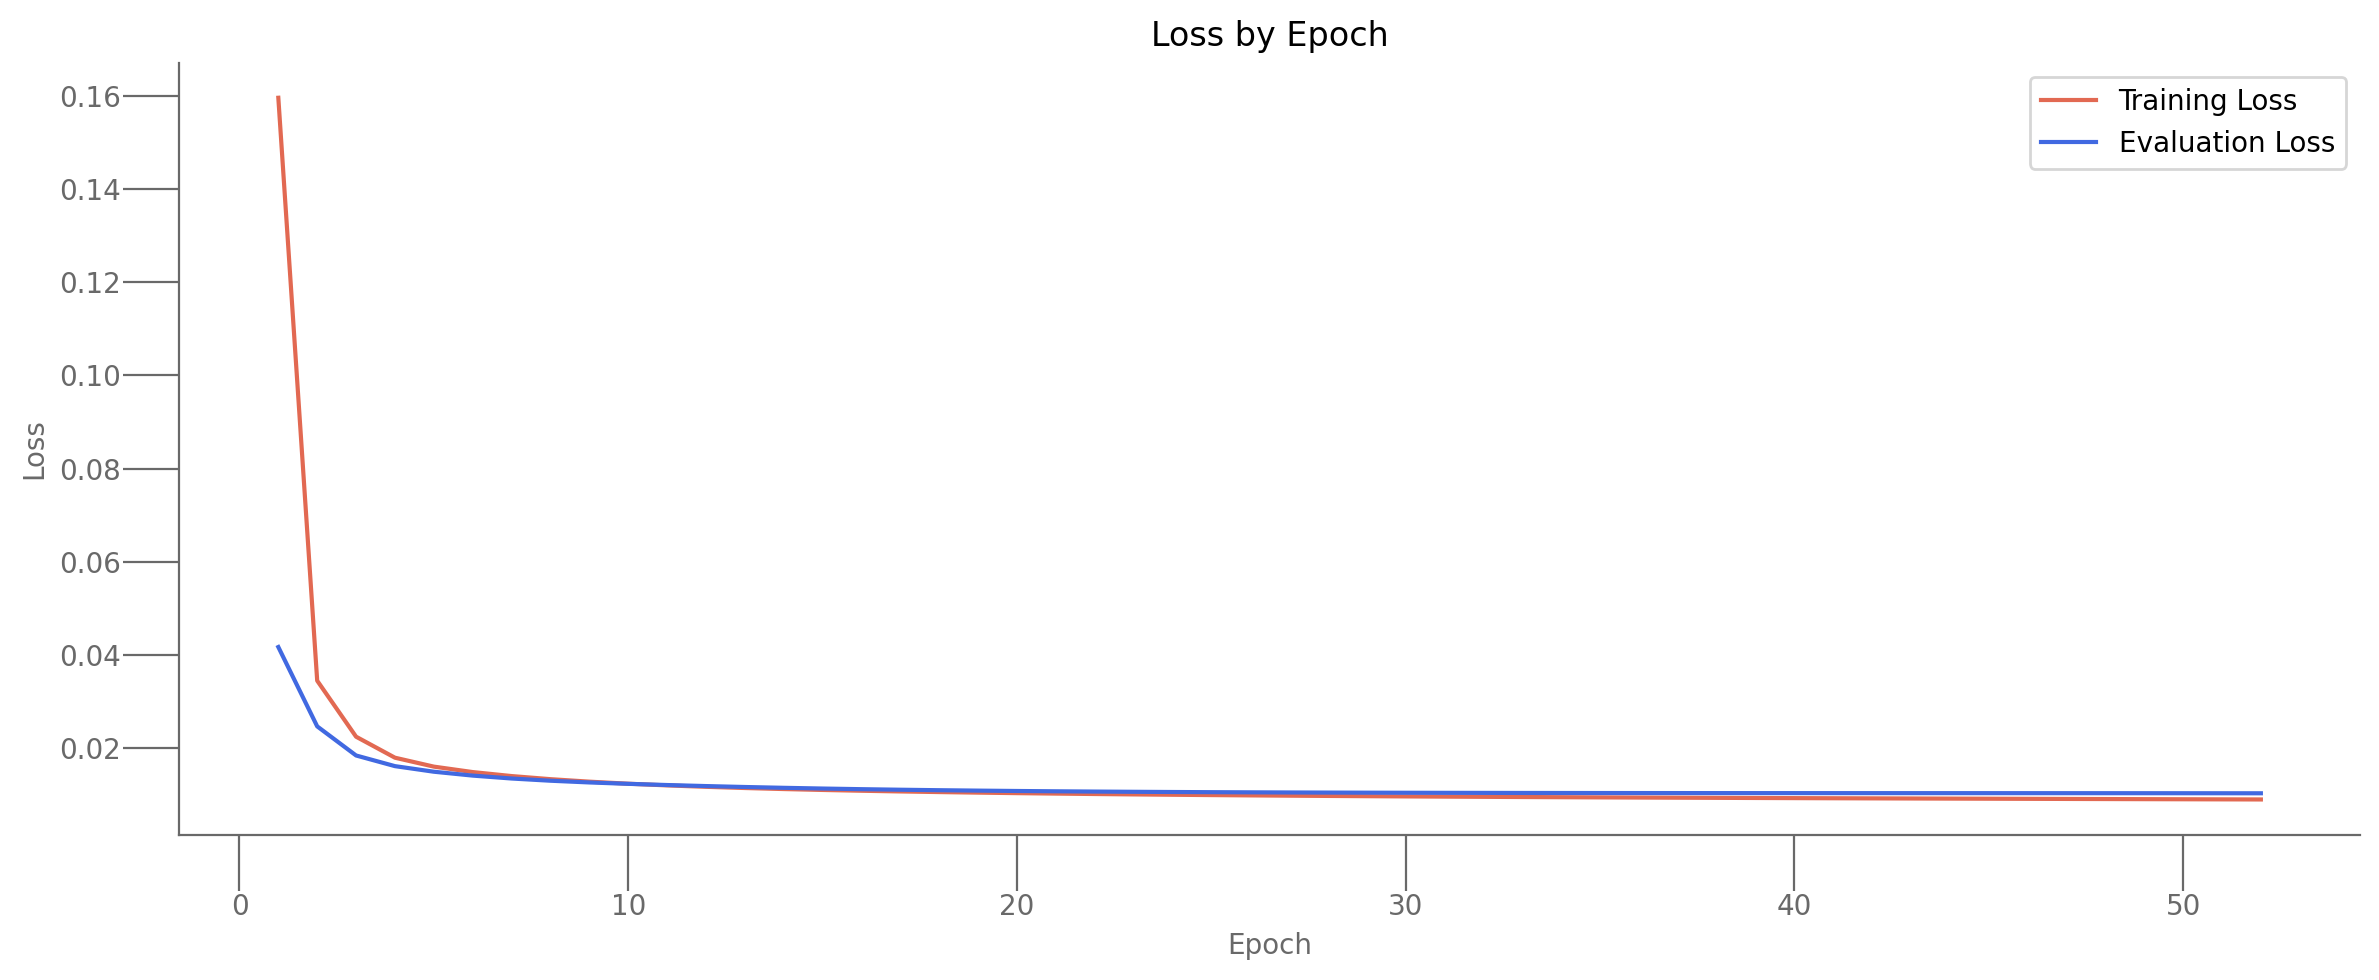


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.007142, test R2 score: -1.783782


In [13]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), len(np.array(losses)), format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_gt, real_gt = trainer_gt.test()

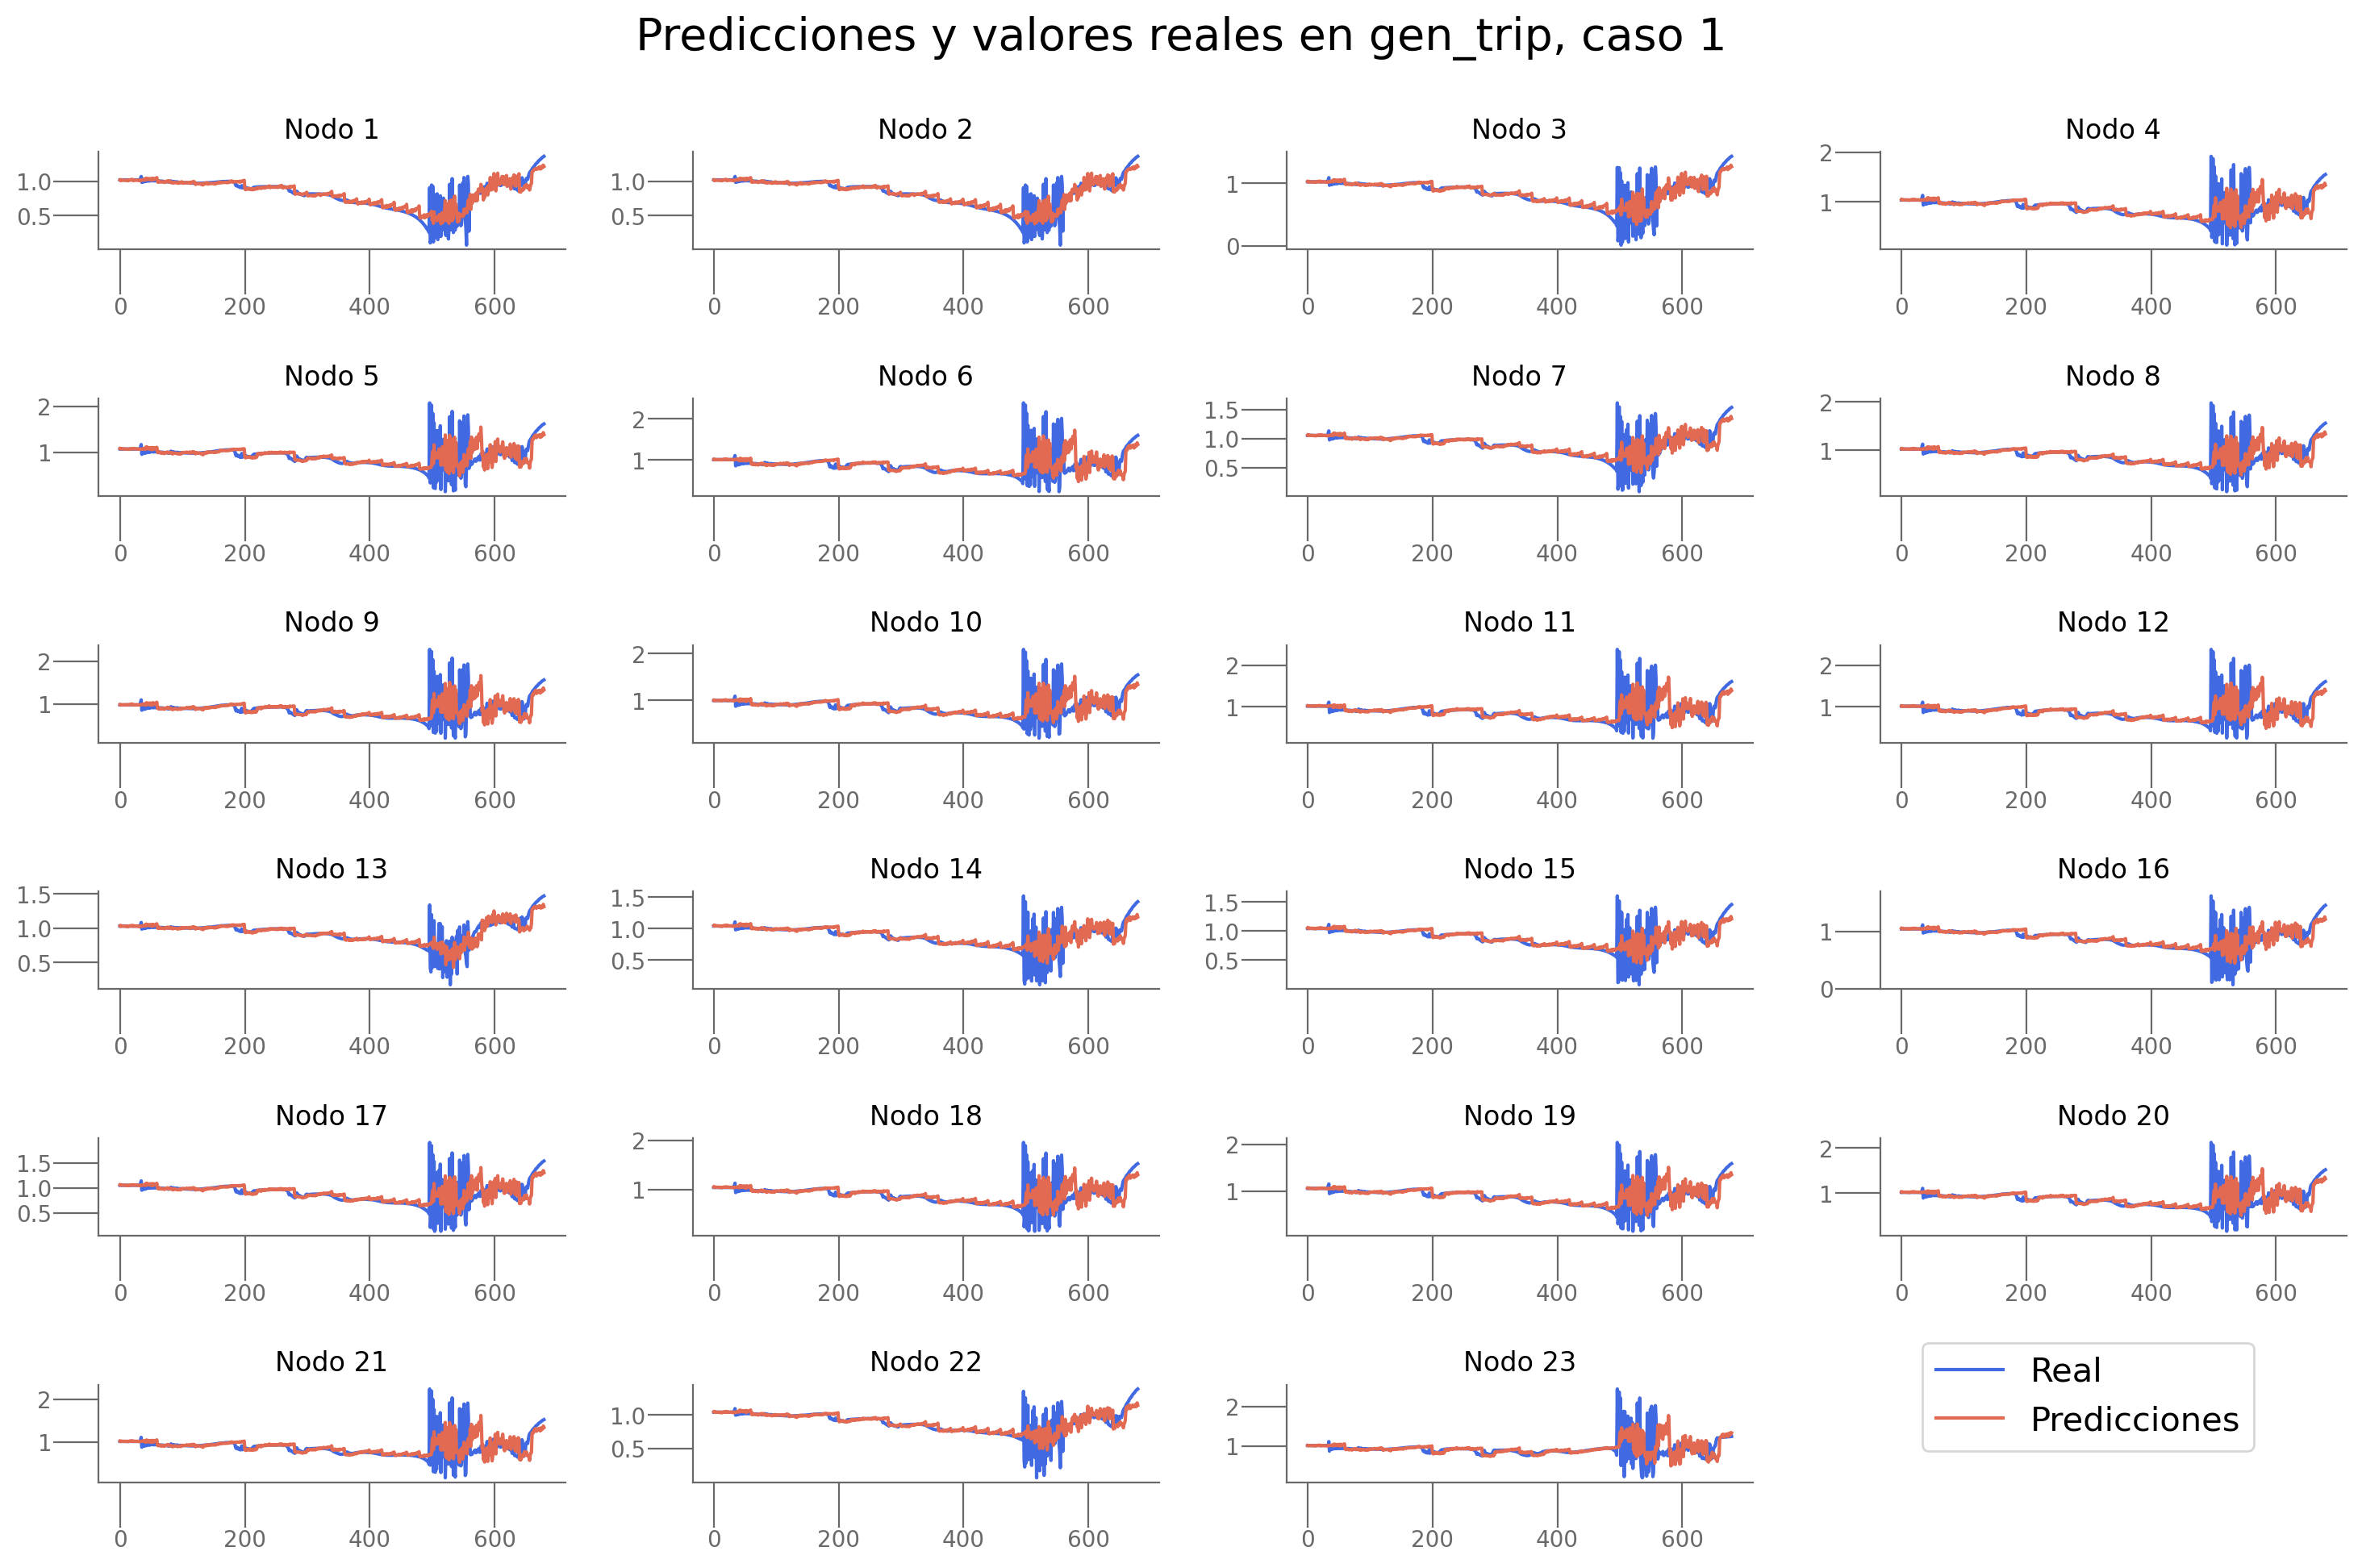

In [14]:
plot_predictions(predictions_gt, real_gt, n_target, 1, n_div_gt, problem_gt)

In [15]:
trainer_gt.save_path = f"../experimentos_split/results/{problem_gt}"

In [17]:
trainer_gt.model.name = "ASTGCN"

In [19]:
trainer_gt.save_model(params={"nb_block":1, "K":2, "nb_chev_filter" : 3, "nb_time_filter" :3, "time_strides" : 2, "hidden":100})


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1     MPNN_LSTM                {'hidden_size': 16, 'dropout': 0.2}   
2  LSTM_NOBATCH                                                NaN   
3   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 1}   
4     EvolveGCN                                                NaN   
5         AGCRN            {'hidden': 10, 'K': 10, 'embedding': 3}   
6        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
7         DCRNN                                     {'hidden': 10}   
8        MSTGCN                                                NaN   
9        MSTGCN  {'nb_block': 1, 'K': 2, 'nb_chev_filter': 3, '...   

                      Fichero_resultados_experimento  Loss_tst     R2_tst  \
0                                                NaN  0.007638   0.204209   
1    ./resu

#### Ajuste de parámetros 

In [35]:

param_grid = {
    "nb_block": [1, 2, 3],
    "filter": [2,4,8],
    "time_strides": [1, 2, 4]
}

num_epochs = 100
num_early_stop = 10

trainer_gt,params_gt, resultados_final_gt, resultados_gt = entrenar_y_evaluar_modelos_mstgcn(param_grid, dataset_gt, dataloader_params2, num_early_stop, num_epochs, problem=problem_gt)

  0%|          | 0/27 [00:00<?, ?it/s]

Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=1

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0.4321 | Eval Loss: 0.3054 | Eval R2: -131.4407 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 0.2647 | Eval Loss: 0.2306 | Eval R2: -94.5521 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 0.2082 | Eval Loss: 0.1755 | Eval R2: -69.2208 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 0.1420 | Eval Loss: 0.1045 | Eval R2: -33.4264 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 0.0959 | Eval Loss: 0.0855 | Eval R2: -23.4782 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 0.0875 | Eval Loss: 0.0809 | Eval R2: -22.1238 | LR: 0.0010 | 
Epoch 7/100 | Train Loss: 0.0842 | Eval Loss: 0.0785 | Eval R2: -21.2584 | LR: 0.0010 | 
Epoch 8/100 | Train Loss: 0.0822 | Eval Loss: 0.0765 | Eval R2: -20.7972 | LR: 0.0010 | 
Epoch 9/100 | Train Loss: 0.08

  4%|▎         | 1/27 [06:19<2:44:23, 379.36s/it]

preds:  (1, 23, 20)
test loss: 0.018173, test r2score -8.041373
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.023216402158141136, 'r2_eval_final': -6.5363593101501465, 'loss_eval_final': 0.022421741858124733, 'r2_test': -8.041373210086766, 'loss_test': 0.018173128366470337, 'loss_nodes': [[0.014876097440719604, 0.014530775137245655, 0.01558992825448513, 0.014047706499695778, 0.018326815217733383, 0.014743770472705364, 0.0158753152936697, 0.018111873418092728, 0.017594268545508385, 0.015516594983637333, 0.01616179756820202, 0.017751051113009453, 0.01975092478096485, 0.02032194659113884, 0.020377956330776215, 0.01893988624215126, 0.02396208792924881, 0.02176535502076149, 0.02046195976436138, 0.02475651539862156]]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==

  7%|▋         | 2/27 [11:51<2:26:29, 351.58s/it]

preds:  (1, 23, 20)
test loss: 0.044105, test r2score -14.855204
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.06206050142645836, 'r2_eval_final': -14.490979194641113, 'loss_eval_final': 0.056686632335186005, 'r2_test': -14.855203890146889, 'loss_test': 0.044105466455221176, 'loss_nodes': [[0.041279833763837814, 0.04092373698949814, 0.04324406385421753, 0.041257504373788834, 0.04384107515215874, 0.043711110949516296, 0.0460963100194931, 0.0422729067504406, 0.04131663218140602, 0.04242848977446556, 0.043245747685432434, 0.04415062069892883, 0.0438571497797966, 0.044952571392059326, 0.047507692128419876, 0.043092064559459686, 0.047799158841371536, 0.04835837334394455, 0.04640313610434532, 0.04637107998132706]]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=4

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

=====

 11%|█         | 3/27 [17:02<2:13:15, 333.13s/it]

preds:  (1, 23, 20)
test loss: 0.065888, test r2score -21.383784
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.08827188611030579, 'r2_eval_final': -19.76938819885254, 'loss_eval_final': 0.08059532940387726, 'r2_test': -21.38378351899726, 'loss_test': 0.0658884197473526, 'loss_nodes': [[0.06462564319372177, 0.06482360512018204, 0.06676913052797318, 0.0644325539469719, 0.06564788520336151, 0.06398990005254745, 0.06568906456232071, 0.06451069563627243, 0.0658239871263504, 0.06520655006170273, 0.06490503251552582, 0.06704002618789673, 0.06604557484388351, 0.06619400531053543, 0.0673736184835434, 0.06576624512672424, 0.06770320236682892, 0.06775645911693573, 0.06551489233970642, 0.0679502785205841]]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=1

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

===================

 15%|█▍        | 4/27 [23:25<2:15:12, 352.73s/it]

preds:  (1, 23, 20)
test loss: 0.063184, test r2score -37.231284
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.06530307978391647, 'r2_eval_final': -30.385639190673828, 'loss_eval_final': 0.0676840990781784, 'r2_test': -37.23128444559395, 'loss_test': 0.06318444013595581, 'loss_nodes': [[0.002120547229424119, 0.006072360556572676, 0.005484574008733034, 0.0042953272350132465, 0.0074873678386211395, 0.004605814348906279, 0.006498128641396761, 0.005635974928736687, 0.00631168344989419, 0.005243516527116299, 1.105750560760498, 0.009035077877342701, 0.009412456303834915, 0.011059005744755268, 0.010119861923158169, 0.010162733495235443, 0.015740830451250076, 0.012112780474126339, 0.011323275975883007, 0.015217537991702557]]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 9

 19%|█▊        | 5/27 [29:09<2:08:10, 349.57s/it]

preds:  (1, 23, 20)
test loss: 0.229325, test r2score -141.019250
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.2338154911994934, 'r2_eval_final': -114.46077728271484, 'loss_eval_final': 0.2371997833251953, 'r2_test': -141.01924967392716, 'loss_test': 0.22932545840740204, 'loss_nodes': [[1.104114055633545, 0.0047796317376196384, 0.005907553713768721, 0.004742042161524296, 0.008775681257247925, 0.005625148769468069, 0.005663245916366577, 0.007140944711863995, 0.0061476887203752995, 0.006727233994752169, 0.006192387081682682, 0.010271560400724411, 0.013446362689137459, 0.011373872868716717, 1.1133455038070679, 0.012266336008906364, 0.015066475607454777, 1.1133675575256348, 1.1126822233200073, 0.018873516470193863]]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=4

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942



 22%|██▏       | 6/27 [34:29<1:58:47, 339.39s/it]

preds:  (1, 23, 20)
test loss: 0.009307, test r2score -2.973884
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.012150156311690807, 'r2_eval_final': -2.8836348056793213, 'loss_eval_final': 0.012064856477081776, 'r2_test': -2.973883969846387, 'loss_test': 0.00930743757635355, 'loss_nodes': [[0.0035410362761467695, 0.005480461288243532, 0.006767719052731991, 0.005122572649270296, 0.00857960432767868, 0.005999221932142973, 0.006514274049550295, 0.00674224691465497, 0.008104068227112293, 0.007211095653474331, 0.007689527701586485, 0.008818304166197777, 0.011290705762803555, 0.011512388475239277, 0.012695792131125927, 0.01149122416973114, 0.01572832092642784, 0.014313754625618458, 0.012499723583459854, 0.016046717762947083]]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=1

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 

 26%|██▌       | 7/27 [41:33<2:02:25, 367.25s/it]

preds:  (1, 23, 20)
test loss: 0.283974, test r2score -177.173511
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.28787553310394287, 'r2_eval_final': -142.41795349121094, 'loss_eval_final': 0.2933364808559418, 'r2_test': -177.1735112811328, 'loss_test': 0.2839735448360443, 'loss_nodes': [[0.0023605674505233765, 0.004637998063117266, 1.1078596115112305, 0.004836148116737604, 0.009414619766175747, 0.005161828361451626, 0.007127431686967611, 0.005784627981483936, 1.107917070388794, 0.005379768554121256, 1.105750560760498, 0.00796956941485405, 1.1137882471084595, 0.012658379971981049, 0.01138270366936922, 1.110581636428833, 0.016226062551140785, 0.011589596047997475, 0.01267479918897152, 0.016369367018342018]]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

=========

 30%|██▉       | 8/27 [48:00<1:58:17, 373.57s/it]

preds:  (1, 23, 20)
test loss: 0.062841, test r2score -37.517733
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.06507665663957596, 'r2_eval_final': -30.33774757385254, 'loss_eval_final': 0.06689751148223877, 'r2_test': -37.51773337306495, 'loss_test': 0.06284051388502121, 'loss_nodes': [[0.0017114728689193726, 0.005208647344261408, 0.004895211197435856, 0.004525831434875727, 0.007593950722366571, 0.004631567280739546, 1.1046234369277954, 0.005493522621691227, 0.005407602060586214, 0.005415705498307943, 0.005887644365429878, 0.007982252165675163, 0.007874202914536, 0.011751875281333923, 0.010911674238741398, 0.00983533263206482, 0.014364426955580711, 0.011992366053164005, 0.011944010853767395, 0.014760367572307587]]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=4

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942


 33%|███▎      | 9/27 [53:42<1:49:03, 363.50s/it]

preds:  (1, 23, 20)
test loss: 0.009024, test r2score -2.808666
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.010601689107716084, 'r2_eval_final': -2.650343894958496, 'loss_eval_final': 0.011972799897193909, 'r2_test': -2.8086661107338387, 'loss_test': 0.009024149738252163, 'loss_nodes': [[0.003362419782206416, 0.00599950086325407, 0.006634837482124567, 0.005901429336518049, 0.008209398947656155, 0.005703074857592583, 0.007138311397284269, 0.005704977549612522, 0.006402590312063694, 0.0065744235180318356, 0.007895266637206078, 0.009591217152774334, 0.00963772926479578, 0.012122596614062786, 0.01169406995177269, 0.011852055788040161, 0.015717580914497375, 0.013247057795524597, 0.011946500279009342, 0.015147961676120758]]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=1

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset

 37%|███▋      | 10/27 [1:06:13<2:16:56, 483.34s/it]

preds:  (1, 23, 20)
test loss: 0.066551, test r2score -21.055857
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.08833858370780945, 'r2_eval_final': -19.937734603881836, 'loss_eval_final': 0.08148989081382751, 'r2_test': -21.055857049489713, 'loss_test': 0.06655061990022659, 'loss_nodes': [[0.06563497334718704, 0.06467816233634949, 0.068116694688797, 0.06570029258728027, 0.06556104868650436, 0.06375513225793839, 0.06729737669229507, 0.06553376466035843, 0.06564594805240631, 0.06513696163892746, 0.06524977833032608, 0.0677298754453659, 0.0676545724272728, 0.0663217082619667, 0.0677700787782669, 0.06539971381425858, 0.06941552460193634, 0.0679468959569931, 0.06772854179143906, 0.06873535364866257]]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

===================

 41%|████      | 11/27 [1:16:46<2:21:04, 529.06s/it]

preds:  (1, 23, 20)
test loss: 0.117793, test r2score -56.302546
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.13925892114639282, 'r2_eval_final': -47.48078918457031, 'loss_eval_final': 0.13284173607826233, 'r2_test': -56.3025457725406, 'loss_test': 0.1177927628159523, 'loss_nodes': [[1.104114055633545, 0.06466145813465118, 0.06669046729803085, 0.06451651453971863, 0.0656609833240509, 0.06400374323129654, 0.06551828235387802, 0.06459600478410721, 0.06526929140090942, 0.06558229774236679, 0.06484325975179672, 0.06627551466226578, 0.06601548939943314, 0.06612251698970795, 0.06733537465333939, 0.06559818983078003, 0.06766883283853531, 0.0678962841629982, 0.0655800849199295, 0.06790728121995926]]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=4

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== 

 44%|████▍     | 12/27 [1:26:37<2:16:56, 547.75s/it]

preds:  (1, 23, 20)
test loss: 0.379597, test r2score -224.236782
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.39807942509651184, 'r2_eval_final': -182.73883056640625, 'loss_eval_final': 0.39993515610694885, 'r2_test': -224.23678225838796, 'loss_test': 0.3795968294143677, 'loss_nodes': [[0.06431854516267776, 0.06463295966386795, 0.06672310829162598, 1.1079031229019165, 0.0656687542796135, 0.06392151117324829, 0.06544511765241623, 0.06458376348018646, 1.107917070388794, 0.0653686374425888, 0.06482107192277908, 1.1086198091506958, 0.06600870937108994, 0.06609516590833664, 1.1133455038070679, 0.06547217071056366, 1.1202422380447388, 0.06787244230508804, 0.06553468108177185, 1.117438554763794]]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=1

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== T

 48%|████▊     | 13/27 [1:40:20<2:27:15, 631.14s/it]

preds:  (1, 23, 20)
test loss: 0.174158, test r2score -108.068267
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.1785261482000351, 'r2_eval_final': -86.9439468383789, 'loss_eval_final': 0.18163156509399414, 'r2_test': -108.06826696000202, 'loss_test': 0.1741577833890915, 'loss_nodes': [[0.003646905766800046, 0.005768068600445986, 0.005684214644134045, 1.1079031229019165, 1.1111345291137695, 0.004848920274525881, 0.006973097566515207, 0.006318396423012018, 0.006382632534950972, 0.006882599554955959, 0.006943204440176487, 0.009278875775635242, 0.010025051422417164, 0.01179223321378231, 0.01086643896996975, 0.011111204512417316, 0.015601902268826962, 1.1133675575256348, 0.012486979365348816, 0.01613890565931797]]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

====

 52%|█████▏    | 14/27 [1:51:04<2:17:36, 635.08s/it]

preds:  (1, 23, 20)
test loss: 0.009678, test r2score -3.309834
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.011713960207998753, 'r2_eval_final': -3.146042585372925, 'loss_eval_final': 0.012930933386087418, 'r2_test': -3.3098339109455885, 'loss_test': 0.009677641093730927, 'loss_nodes': [[0.004174551460891962, 0.006236504763364792, 0.006727942265570164, 0.006520542316138744, 0.009296624921262264, 0.005583066958934069, 0.006549068260937929, 0.007970214821398258, 0.006890001241117716, 0.007811186835169792, 0.008305150084197521, 0.009885750710964203, 0.01174034271389246, 0.012788400053977966, 0.011769476346671581, 0.01305348053574562, 0.01589670591056347, 0.014315247535705566, 0.012266842648386955, 0.015771720558404922]]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=4

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset:

 56%|█████▌    | 15/27 [2:00:45<2:03:45, 618.83s/it]

preds:  (1, 23, 20)
test loss: 0.064714, test r2score -37.205342
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.06790314614772797, 'r2_eval_final': -30.62136459350586, 'loss_eval_final': 0.06922577321529388, 'r2_test': -37.20534182650922, 'loss_test': 0.06471395492553711, 'loss_nodes': [[0.004861009772866964, 0.005925701931118965, 0.007012191228568554, 0.007085718214511871, 0.0080563984811306, 0.005826187320053577, 0.007518025115132332, 0.007293028756976128, 0.00889342837035656, 0.007661939132958651, 0.007670915219932795, 0.01108354702591896, 0.010017544031143188, 0.013257836923003197, 0.012359392829239368, 0.011706406250596046, 0.016233308240771294, 0.01288894284516573, 1.1126822233200073, 0.016245512291789055]]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=1

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

=

 59%|█████▉    | 16/27 [2:14:32<2:04:56, 681.50s/it]

preds:  (1, 23, 20)
test loss: 0.118641, test r2score -72.638953
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.12086308002471924, 'r2_eval_final': -58.639095306396484, 'loss_eval_final': 0.12370463460683823, 'r2_test': -72.63895327389541, 'loss_test': 0.11864050477743149, 'loss_nodes': [[1.104114055633545, 0.005621807184070349, 0.005177374929189682, 0.004752060864120722, 0.007590610068291426, 0.006509981118142605, 0.006500924471765757, 0.005214413162320852, 0.007511128671467304, 0.005882160738110542, 0.006810723338276148, 0.009287683293223381, 0.009041682817041874, 1.1144286394119263, 0.010418635793030262, 0.010885950177907944, 0.015088477171957493, 0.01201663352549076, 0.011710948310792446, 0.014245837926864624]]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942


 63%|██████▎   | 17/27 [2:29:15<2:03:41, 742.18s/it]

preds:  (1, 23, 20)
test loss: 0.007547, test r2score -1.933839
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.009062101133167744, 'r2_eval_final': -1.8141757249832153, 'loss_eval_final': 0.010265002958476543, 'r2_test': -1.9338393391800293, 'loss_test': 0.007547078188508749, 'loss_nodes': [[0.0017025080742314458, 0.005309256259351969, 0.004439411219209433, 0.004234903492033482, 0.007717794738709927, 0.004596906714141369, 0.004618976265192032, 0.004499135073274374, 0.006283499766141176, 0.004976384807378054, 0.005072656087577343, 0.00813883263617754, 0.008132210932672024, 0.010852938517928123, 0.009797072038054466, 0.010030869394540787, 0.014025311917066574, 0.01154276728630066, 0.01144034881144762, 0.01352976355701685]]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=4

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset

 67%|██████▋   | 18/27 [2:41:17<1:50:25, 736.12s/it]

preds:  (1, 23, 20)
test loss: 0.063770, test r2score -37.752358
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.06658634543418884, 'r2_eval_final': -30.711015701293945, 'loss_eval_final': 0.06791116297245026, 'r2_test': -37.75235772262313, 'loss_test': 0.06377027928829193, 'loss_nodes': [[0.003408130258321762, 0.004909242503345013, 0.0059465812519192696, 0.0050714872777462006, 0.007675518281757832, 0.004988117143511772, 0.005938132759183645, 0.006573703605681658, 1.107917070388794, 0.007124281954020262, 0.006307905074208975, 0.008859088644385338, 0.009976876899600029, 0.010777824558317661, 0.012367966584861279, 0.011355140246450901, 0.014320133253932, 0.01359913032501936, 0.011824077926576138, 0.01646464318037033]]}
Entrenando modelo con nb_block=3, nb_chev_filter=2, nb_time_filter=2, time_strides=1

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942


 70%|███████   | 19/27 [2:59:50<1:53:13, 849.23s/it]

preds:  (1, 23, 20)
test loss: 0.222378, test r2score -122.909538
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.24290022253990173, 'r2_eval_final': -101.50276947021484, 'loss_eval_final': 0.2390679121017456, 'r2_test': -122.90953799058741, 'loss_test': 0.2223782241344452, 'loss_nodes': [[1.104114055633545, 0.06555316597223282, 0.06715227663516998, 0.0648641437292099, 0.06522756069898605, 0.06406289339065552, 0.06564918160438538, 0.0640878826379776, 0.06547530740499496, 1.1053069829940796, 0.06530142575502396, 0.0671752467751503, 0.06630309671163559, 0.06683872640132904, 0.06780508905649185, 0.06587579101324081, 0.06781953573226929, 0.06814306229352951, 1.1126822233200073, 0.06812768429517746]]}
Entrenando modelo con nb_block=3, nb_chev_filter=2, nb_time_filter=2, time_strides=2

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

====================

 74%|███████▍  | 20/27 [3:15:16<1:41:45, 872.27s/it]

preds:  (1, 23, 20)
test loss: 0.274294, test r2score -158.023005
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.2946888208389282, 'r2_eval_final': -129.29510498046875, 'loss_eval_final': 0.2930457890033722, 'r2_test': -158.02300480444225, 'loss_test': 0.27429381012916565, 'loss_nodes': [[1.104114055633545, 0.06469129025936127, 0.0666118636727333, 1.1079031229019165, 0.0658392459154129, 0.06376227736473083, 0.06570291519165039, 0.06445575505495071, 0.0665510967373848, 0.06514155864715576, 1.105750560760498, 1.1086198091506958, 0.06597115099430084, 0.06617504358291626, 0.0672140046954155, 0.06600257009267807, 0.06893114745616913, 0.06821973621845245, 0.06623117625713348, 0.0679885745048523]]}
Entrenando modelo con nb_block=3, nb_chev_filter=2, nb_time_filter=2, time_strides=4

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== TRA

 78%|███████▊  | 21/27 [3:29:00<1:25:47, 857.84s/it]

preds:  (1, 23, 20)
test loss: 0.065781, test r2score -21.659402
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.08730633556842804, 'r2_eval_final': -19.798566818237305, 'loss_eval_final': 0.08037429302930832, 'r2_test': -21.659402139198626, 'loss_test': 0.0657811090350151, 'loss_nodes': [[0.06428132206201553, 0.06466379016637802, 0.06673478335142136, 0.06443969160318375, 0.06565457582473755, 0.06388068199157715, 0.0658021941781044, 0.06461088359355927, 0.06524049490690231, 0.06527891010046005, 0.0648387148976326, 0.06632547080516815, 0.06601884216070175, 0.06619590520858765, 0.06724124401807785, 0.06542780250310898, 0.06769950687885284, 0.0678519532084465, 0.06558959931135178, 0.06784576922655106]]}
Entrenando modelo con nb_block=3, nb_chev_filter=4, nb_time_filter=4, time_strides=1

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

================

 81%|████████▏ | 22/27 [3:47:26<1:17:41, 932.26s/it]

preds:  (1, 23, 20)
test loss: 0.008733, test r2score -2.671774
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.011219033971428871, 'r2_eval_final': -2.532061815261841, 'loss_eval_final': 0.011821419931948185, 'r2_test': -2.671773622785409, 'loss_test': 0.008732864633202553, 'loss_nodes': [[0.002829525154083967, 0.005163575056940317, 0.0057181017473340034, 0.005179754924029112, 0.007337494287639856, 0.005287043750286102, 0.006071174517273903, 0.006535399705171585, 0.006772122345864773, 0.006259285379201174, 0.006478997878730297, 0.00928706955164671, 0.009687485173344612, 0.011449421755969524, 0.012453221715986729, 0.011302107013761997, 0.014977028593420982, 0.01345719676464796, 0.011263354681432247, 0.01714794524013996]]}
Entrenando modelo con nb_block=3, nb_chev_filter=4, nb_time_filter=4, time_strides=2

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset:

 85%|████████▌ | 23/27 [4:03:02<1:02:13, 933.31s/it]

preds:  (1, 23, 20)
test loss: 0.064674, test r2score -38.417716
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.06783943623304367, 'r2_eval_final': -31.316120147705078, 'loss_eval_final': 0.06923718750476837, 'r2_test': -38.41771584123241, 'loss_test': 0.06467363238334656, 'loss_nodes': [[0.004580644890666008, 0.005598081275820732, 0.006401379592716694, 0.00769082410261035, 0.008551831357181072, 1.107574224472046, 0.007346105296164751, 0.007152155973017216, 0.007422456983476877, 0.00884222611784935, 0.007688977289944887, 0.009916889481246471, 0.010009226389229298, 0.011973535642027855, 0.01273753959685564, 0.012663906440138817, 0.014815949834883213, 0.01397821307182312, 0.012236520648002625, 0.01629205048084259]]}
Entrenando modelo con nb_block=3, nb_chev_filter=4, nb_time_filter=4, time_strides=4

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

=

 89%|████████▉ | 24/27 [4:17:27<45:38, 912.86s/it]  

preds:  (1, 23, 20)
test loss: 0.011715, test r2score -3.964492
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.014686603099107742, 'r2_eval_final': -3.724929094314575, 'loss_eval_final': 0.014313988387584686, 'r2_test': -3.9644922167117116, 'loss_test': 0.011714554391801357, 'loss_nodes': [[0.006210857070982456, 0.007290813140571117, 0.007952338084578514, 0.00806930661201477, 0.00942178163677454, 0.009160039946436882, 0.01111676823347807, 0.009883868508040905, 0.008851833641529083, 0.009341860190033913, 0.00954007264226675, 0.01260401587933302, 0.013394543901085854, 0.014714709483087063, 0.015852129086852074, 0.014184406958520412, 0.01768912933766842, 0.01620696485042572, 0.014404543675482273, 0.01840110309422016]]}
Entrenando modelo con nb_block=3, nb_chev_filter=8, nb_time_filter=8, time_strides=1

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942


 93%|█████████▎| 25/27 [4:39:02<34:15, 1027.52s/it]

preds:  (1, 23, 20)
test loss: 0.118774, test r2score -72.169043
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.12197461724281311, 'r2_eval_final': -58.37848663330078, 'loss_eval_final': 0.12417814880609512, 'r2_test': -72.16904327726162, 'loss_test': 0.11877363920211792, 'loss_nodes': [[0.002594615099951625, 0.007015422452241182, 0.005402161739766598, 0.005751077085733414, 0.007544865366071463, 0.005556662566959858, 0.00598499970510602, 0.005730817094445229, 0.00749550573527813, 0.006586933974176645, 1.105750560760498, 0.008442358113825321, 0.008575244806706905, 1.1144286394119263, 0.013953568413853645, 0.009655438363552094, 0.013765479438006878, 0.013734946958720684, 0.010892592370510101, 0.01661098189651966]]}
Entrenando modelo con nb_block=3, nb_chev_filter=8, nb_time_filter=8, time_strides=2

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==

 96%|█████████▋| 26/27 [4:56:46<17:18, 1038.47s/it]

preds:  (1, 23, 20)
test loss: 0.117757, test r2score -70.279183
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.12128999084234238, 'r2_eval_final': -57.2574348449707, 'loss_eval_final': 0.12335936725139618, 'r2_test': -70.27918299364158, 'loss_test': 0.11775658279657364, 'loss_nodes': [[0.002411690540611744, 0.00467948243021965, 0.0057653384283185005, 0.004174868110567331, 0.007276072166860104, 0.004929852671921253, 0.005477860104292631, 0.0053619579412043095, 0.005544757936149836, 0.005326627753674984, 0.0057034846395254135, 0.007595357019454241, 0.00832259003072977, 0.009860814549028873, 0.010087648406624794, 0.009385714307427406, 0.01362163107842207, 1.1133675575256348, 1.1126822233200073, 0.013555643148720264]]}
Entrenando modelo con nb_block=3, nb_chev_filter=8, nb_time_filter=8, time_strides=4

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942


100%|██████████| 27/27 [5:12:17<00:00, 693.99s/it] 

preds:  (1, 23, 20)
test loss: 0.064503, test r2score -38.856991
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.06757090240716934, 'r2_eval_final': -31.71665382385254, 'loss_eval_final': 0.0687304213643074, 'r2_test': -38.856991348598676, 'loss_test': 0.06450299173593521, 'loss_nodes': [[0.0038055097684264183, 1.108215570449829, 0.006585355382412672, 0.0065266103483736515, 0.008095023222267628, 0.006178805138915777, 0.007497031707316637, 0.007101719733327627, 0.007290371228009462, 0.00706695020198822, 0.007014179136604071, 0.010137236677110195, 0.010196879506111145, 0.011855167336761951, 0.012877995148301125, 0.011648342944681644, 0.01568145491182804, 0.013757907785475254, 0.012361805886030197, 0.016166510060429573]]}


In [36]:
losses_tst, r2score_tst, loss_nodes, predictions, real = trainer_gt.test()



==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.007547, test r2score -1.933836


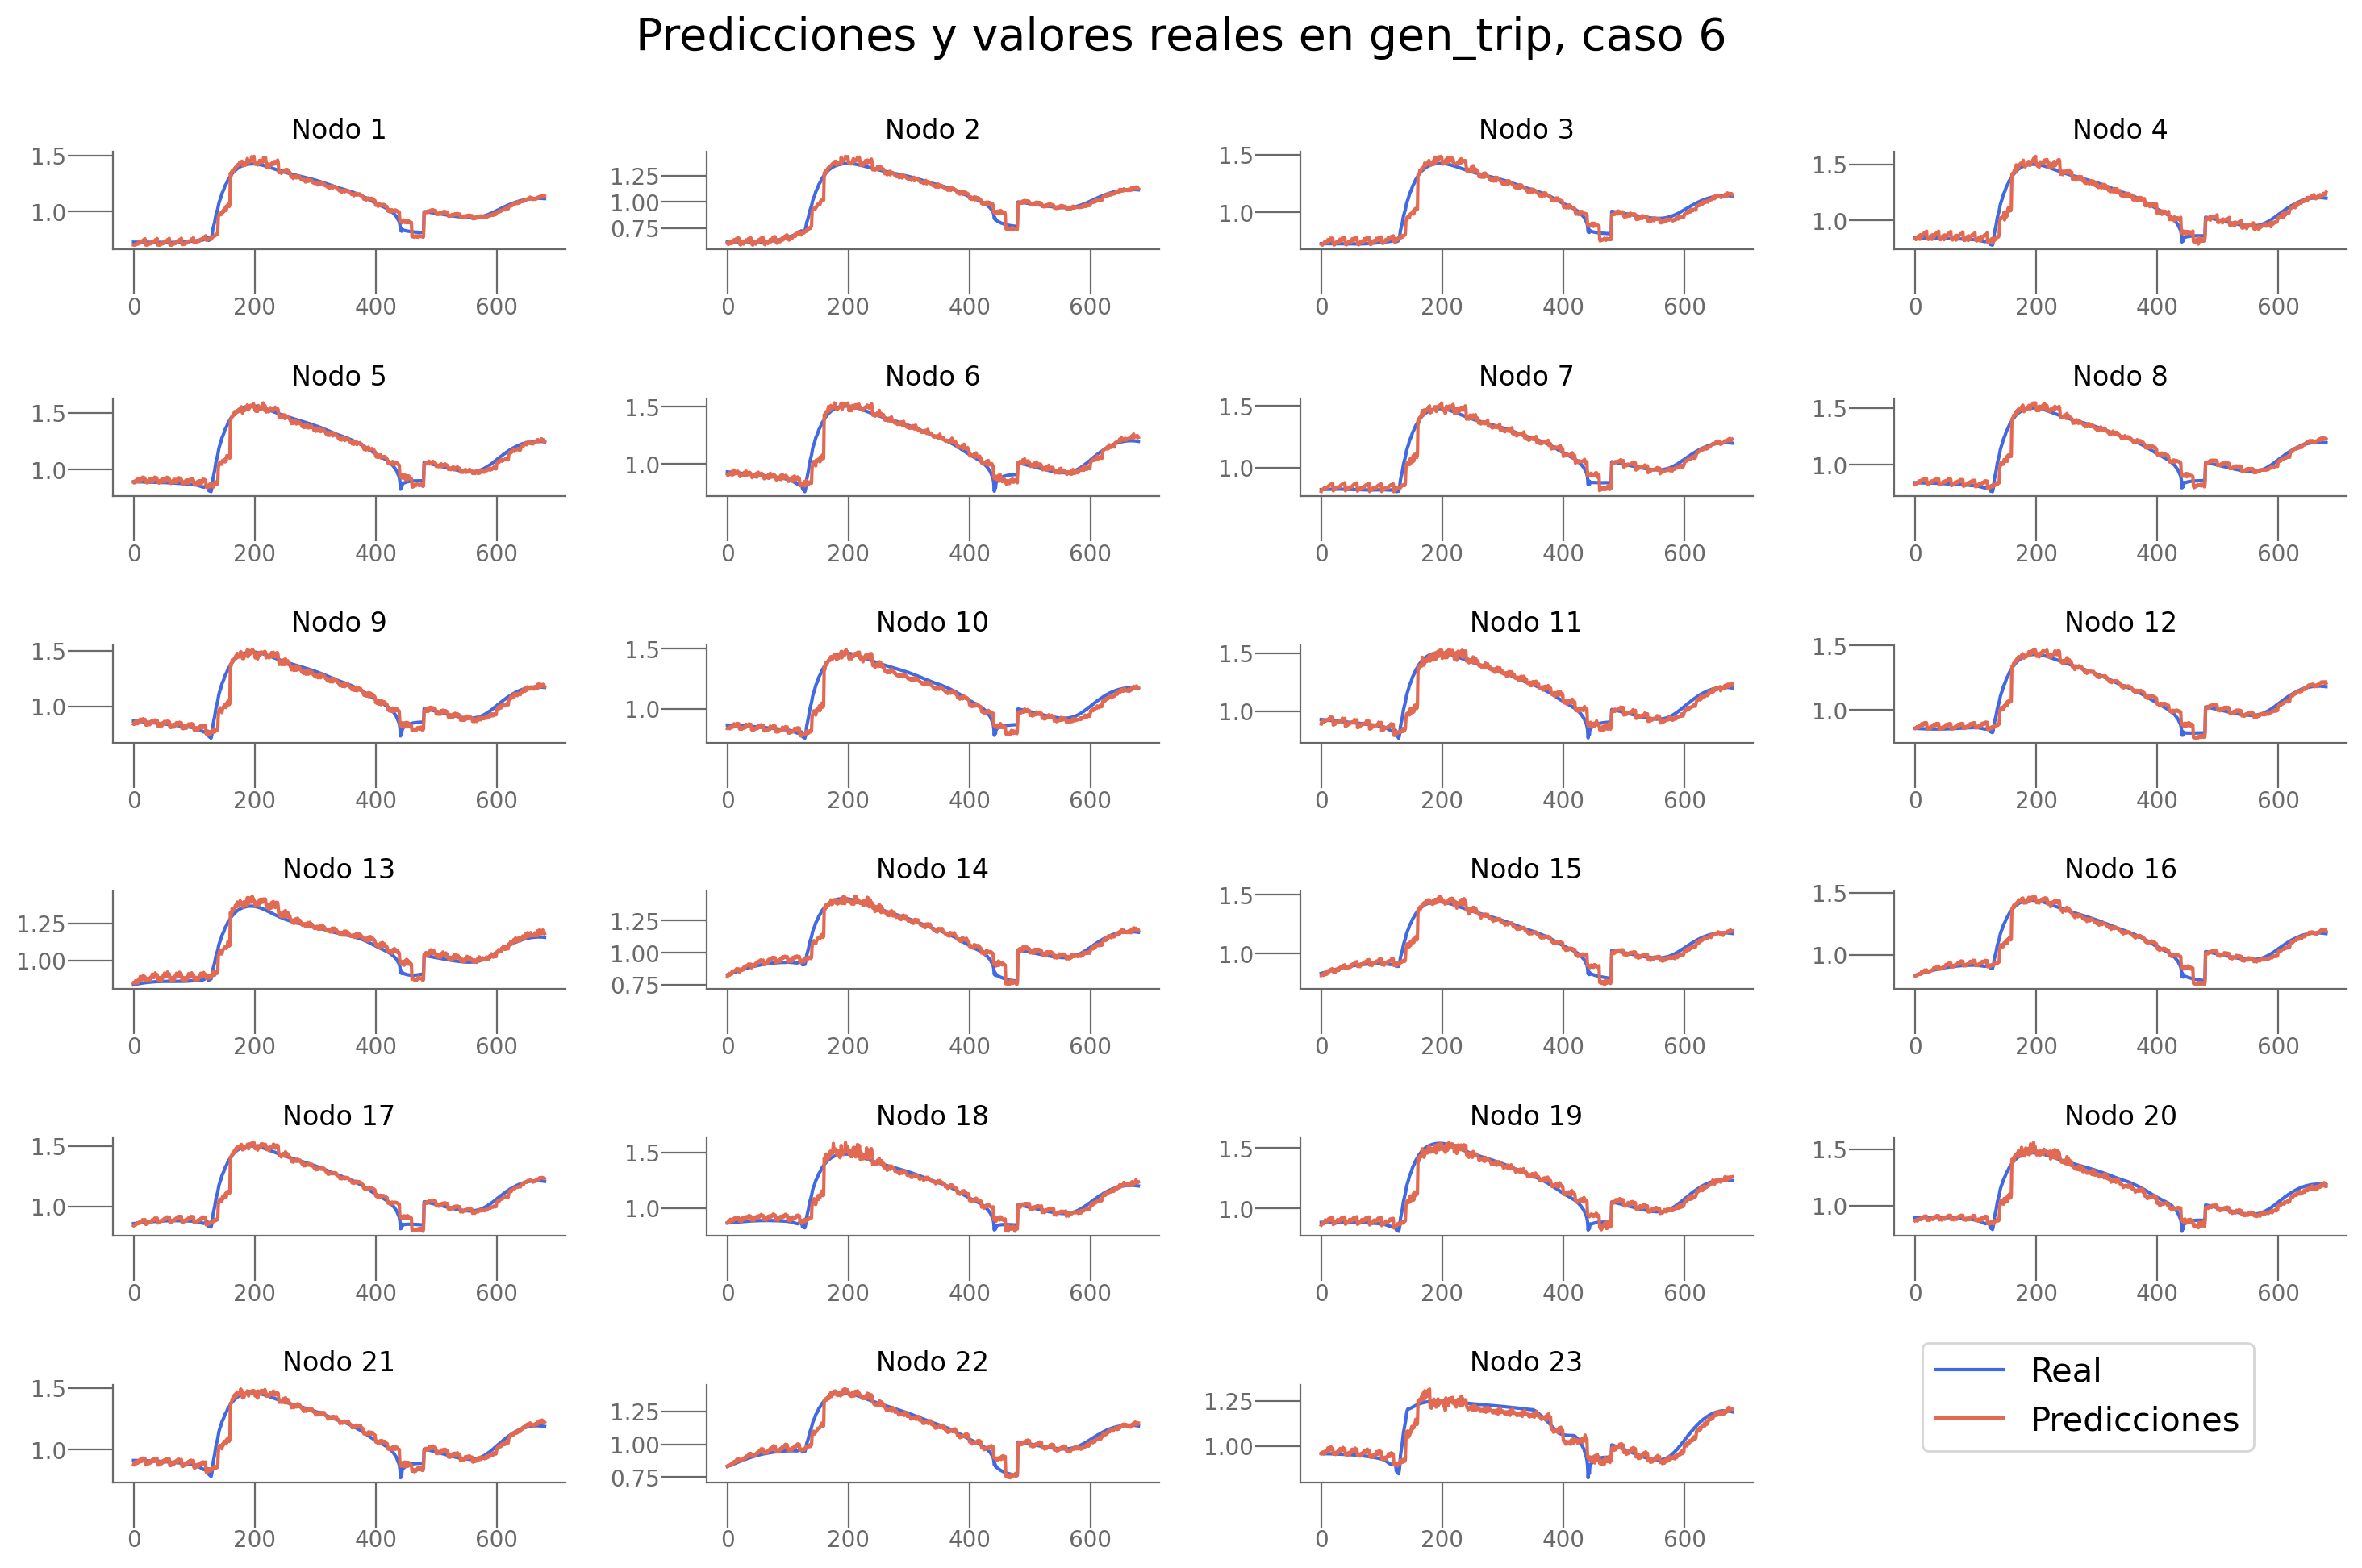

In [37]:
plot_predictions(predictions, real, n_target, 6, n_div_gt, problem_gt)

In [38]:
path_save_experiment_gt = results_save_path+f"/{problem_gt}"+ f"/ajustes/{name_model}_results.csv"
resultados_gt.to_csv(path_save_experiment_gt, index=False)

In [39]:
trainer_gt.save_model(params=params_gt, path_save_experiment= path_save_experiment_gt)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1     MPNN_LSTM                {'hidden_size': 16, 'dropout': 0.2}   
2  LSTM_NOBATCH                                                NaN   
3   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 1}   
4         AGCRN                              {'hidden': 5, 'K': 2}   
5        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   

                      Fichero_resultados_experimento  Loss_tst     R2_tst  \
0                                                NaN  0.007638   0.204209   
1    ./results/gen_trip/ajustes/MPNNLSTM_results.csv  0.045889 -18.247558   
2                                                NaN  0.007437  -1.985579   
3  ./results/gen_trip/ajustes/DryGrEncoder_result...  0.006246  -1.204836   
4       ./results/gen_trip/ajustes/AGCRN_results.csv  0.0085

### Bus trip

In [20]:
problem_bt = "bus_trip"
dataset_bt, situations_bt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_bt)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [29]:
n_div_bt = loader.div
n_nodes =dataset_bt.features[0].shape[0]
n_target = dataset_bt.targets[0].shape[1]
n_features = dataset_bt[0].x.shape[1]


num_early_stop = 10
num_epochs = 100
lr = 0.01

#### Sencilla 

In [30]:

device =  torch.device("cpu")
model_bt = ASTGCNModel(name="ASTGCN", node_features=n_features, node_count=n_nodes, n_target=n_target, nb_block=1, k=2, nb_chev_filter = 2, nb_time_filter =2, time_strides = 2, hidden_size=50)

trainer_bt = TrainerMSTGCN(model_bt, dataset_bt,device, f"../experimentos_split/results/{problem_bt}", dataloader_params2)


losses,eval_losses, r2scores  = trainer_bt.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)





==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0.3208 | Eval Loss: 0.2216 | Eval R2: -5.8777 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 0.1469 | Eval Loss: 0.0909 | Eval R2: -1.1196 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 0.0877 | Eval Loss: 0.0776 | Eval R2: -0.8074 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 0.0698 | Eval Loss: 0.0571 | Eval R2: -0.6480 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 0.0593 | Eval Loss: 0.0537 | Eval R2: -0.4720 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 0.0567 | Eval Loss: 0.0510 | Eval R2: -0.5463 | LR: 0.0010 | 
Epoch 7/100 | Train Loss: 0.0545 | Eval Loss: 0.0491 | Eval R2: -0.5261 | LR: 0.0010 | 
Epoch 8/100 | Train Loss: 0.0526 | Eval Loss: 0.0482 | Eval R2: -0.4145 | LR: 0.0010 | 
Epoch 9/100 | Train Loss: 0.0510 | Eval Loss: 0.0466 | Eval R2: -0.3712 | LR: 0.0010 | 
Epoch 10/100 | Train Loss: 0.0497 | 

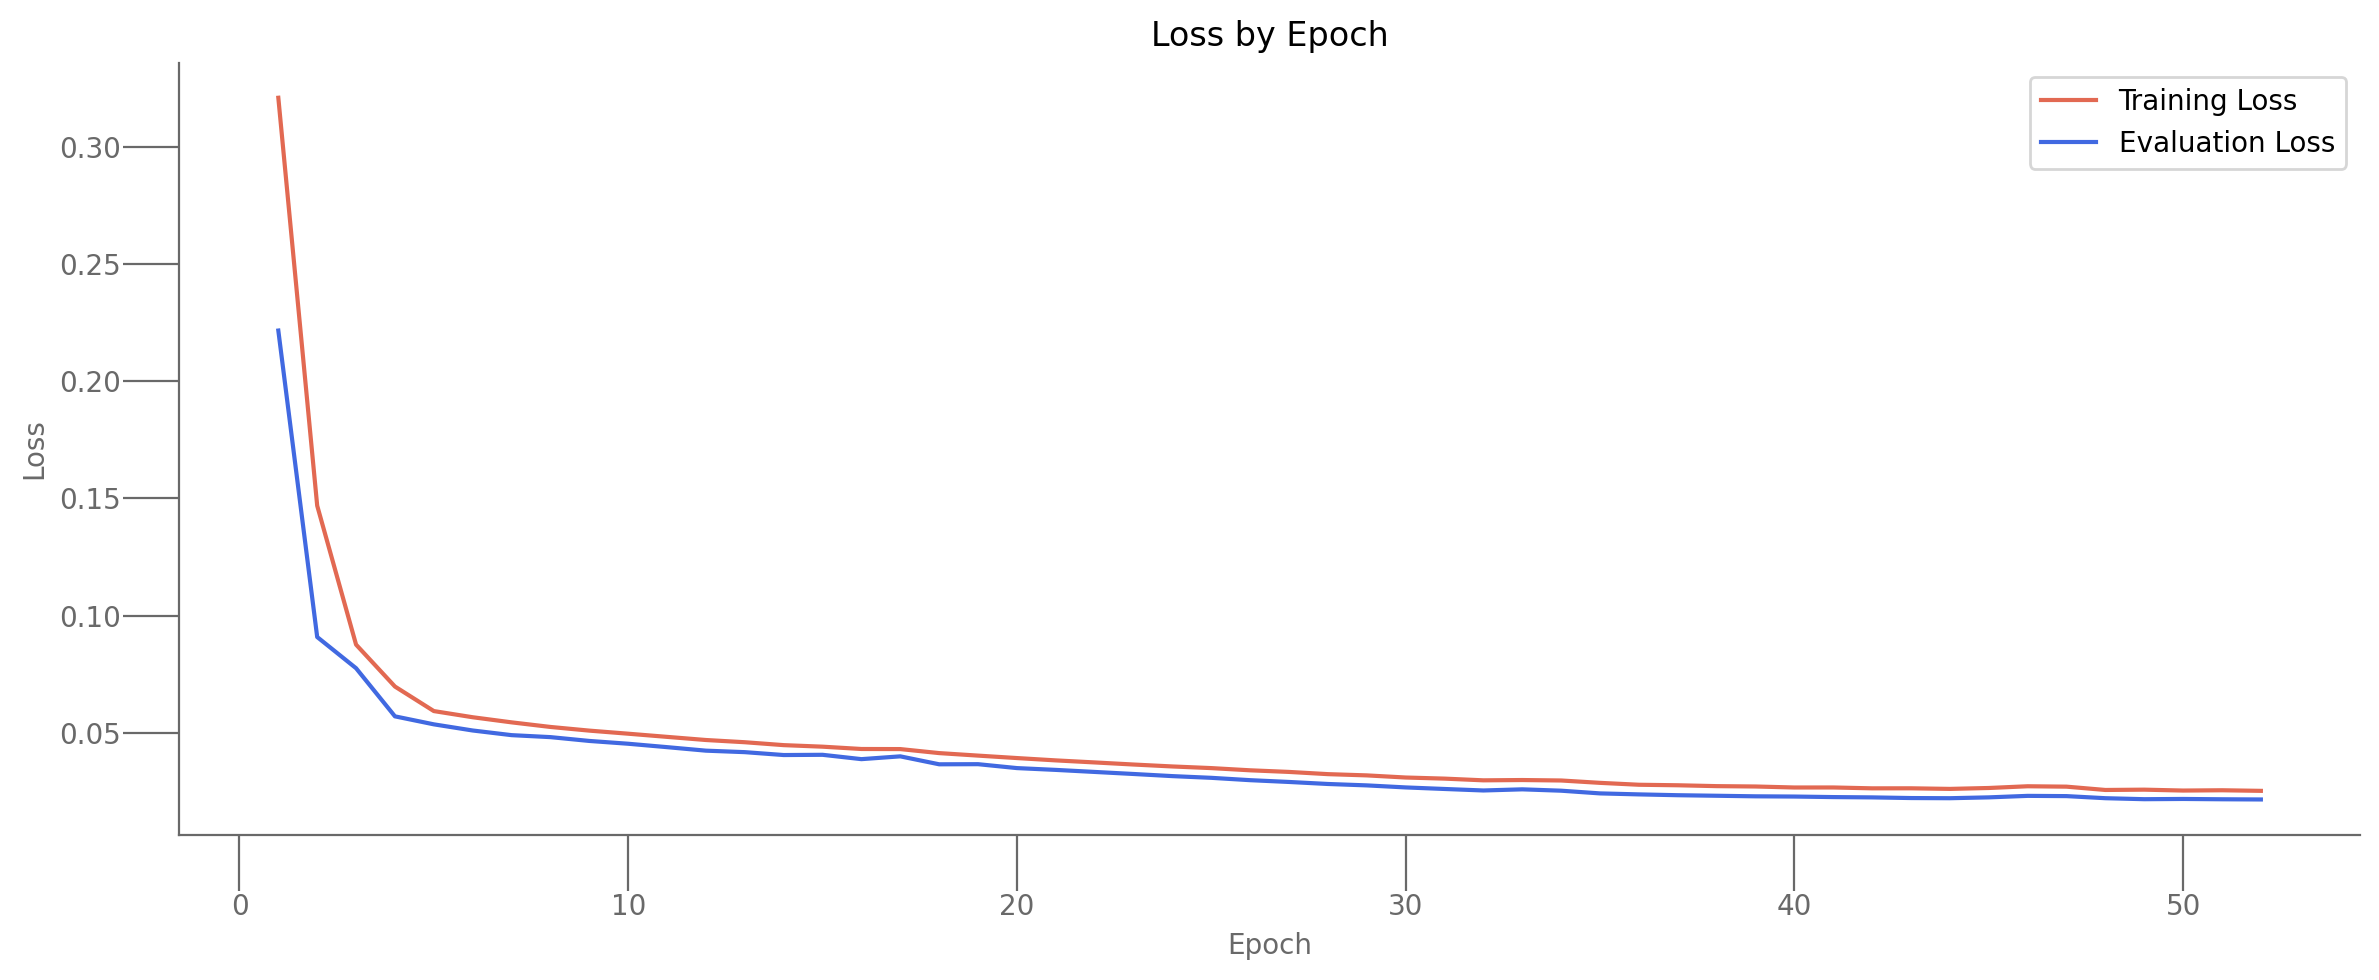


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.024169, test R2 score: 0.274406


In [31]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), len(np.array(losses)), format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_bt, real_bt = trainer_bt.test()

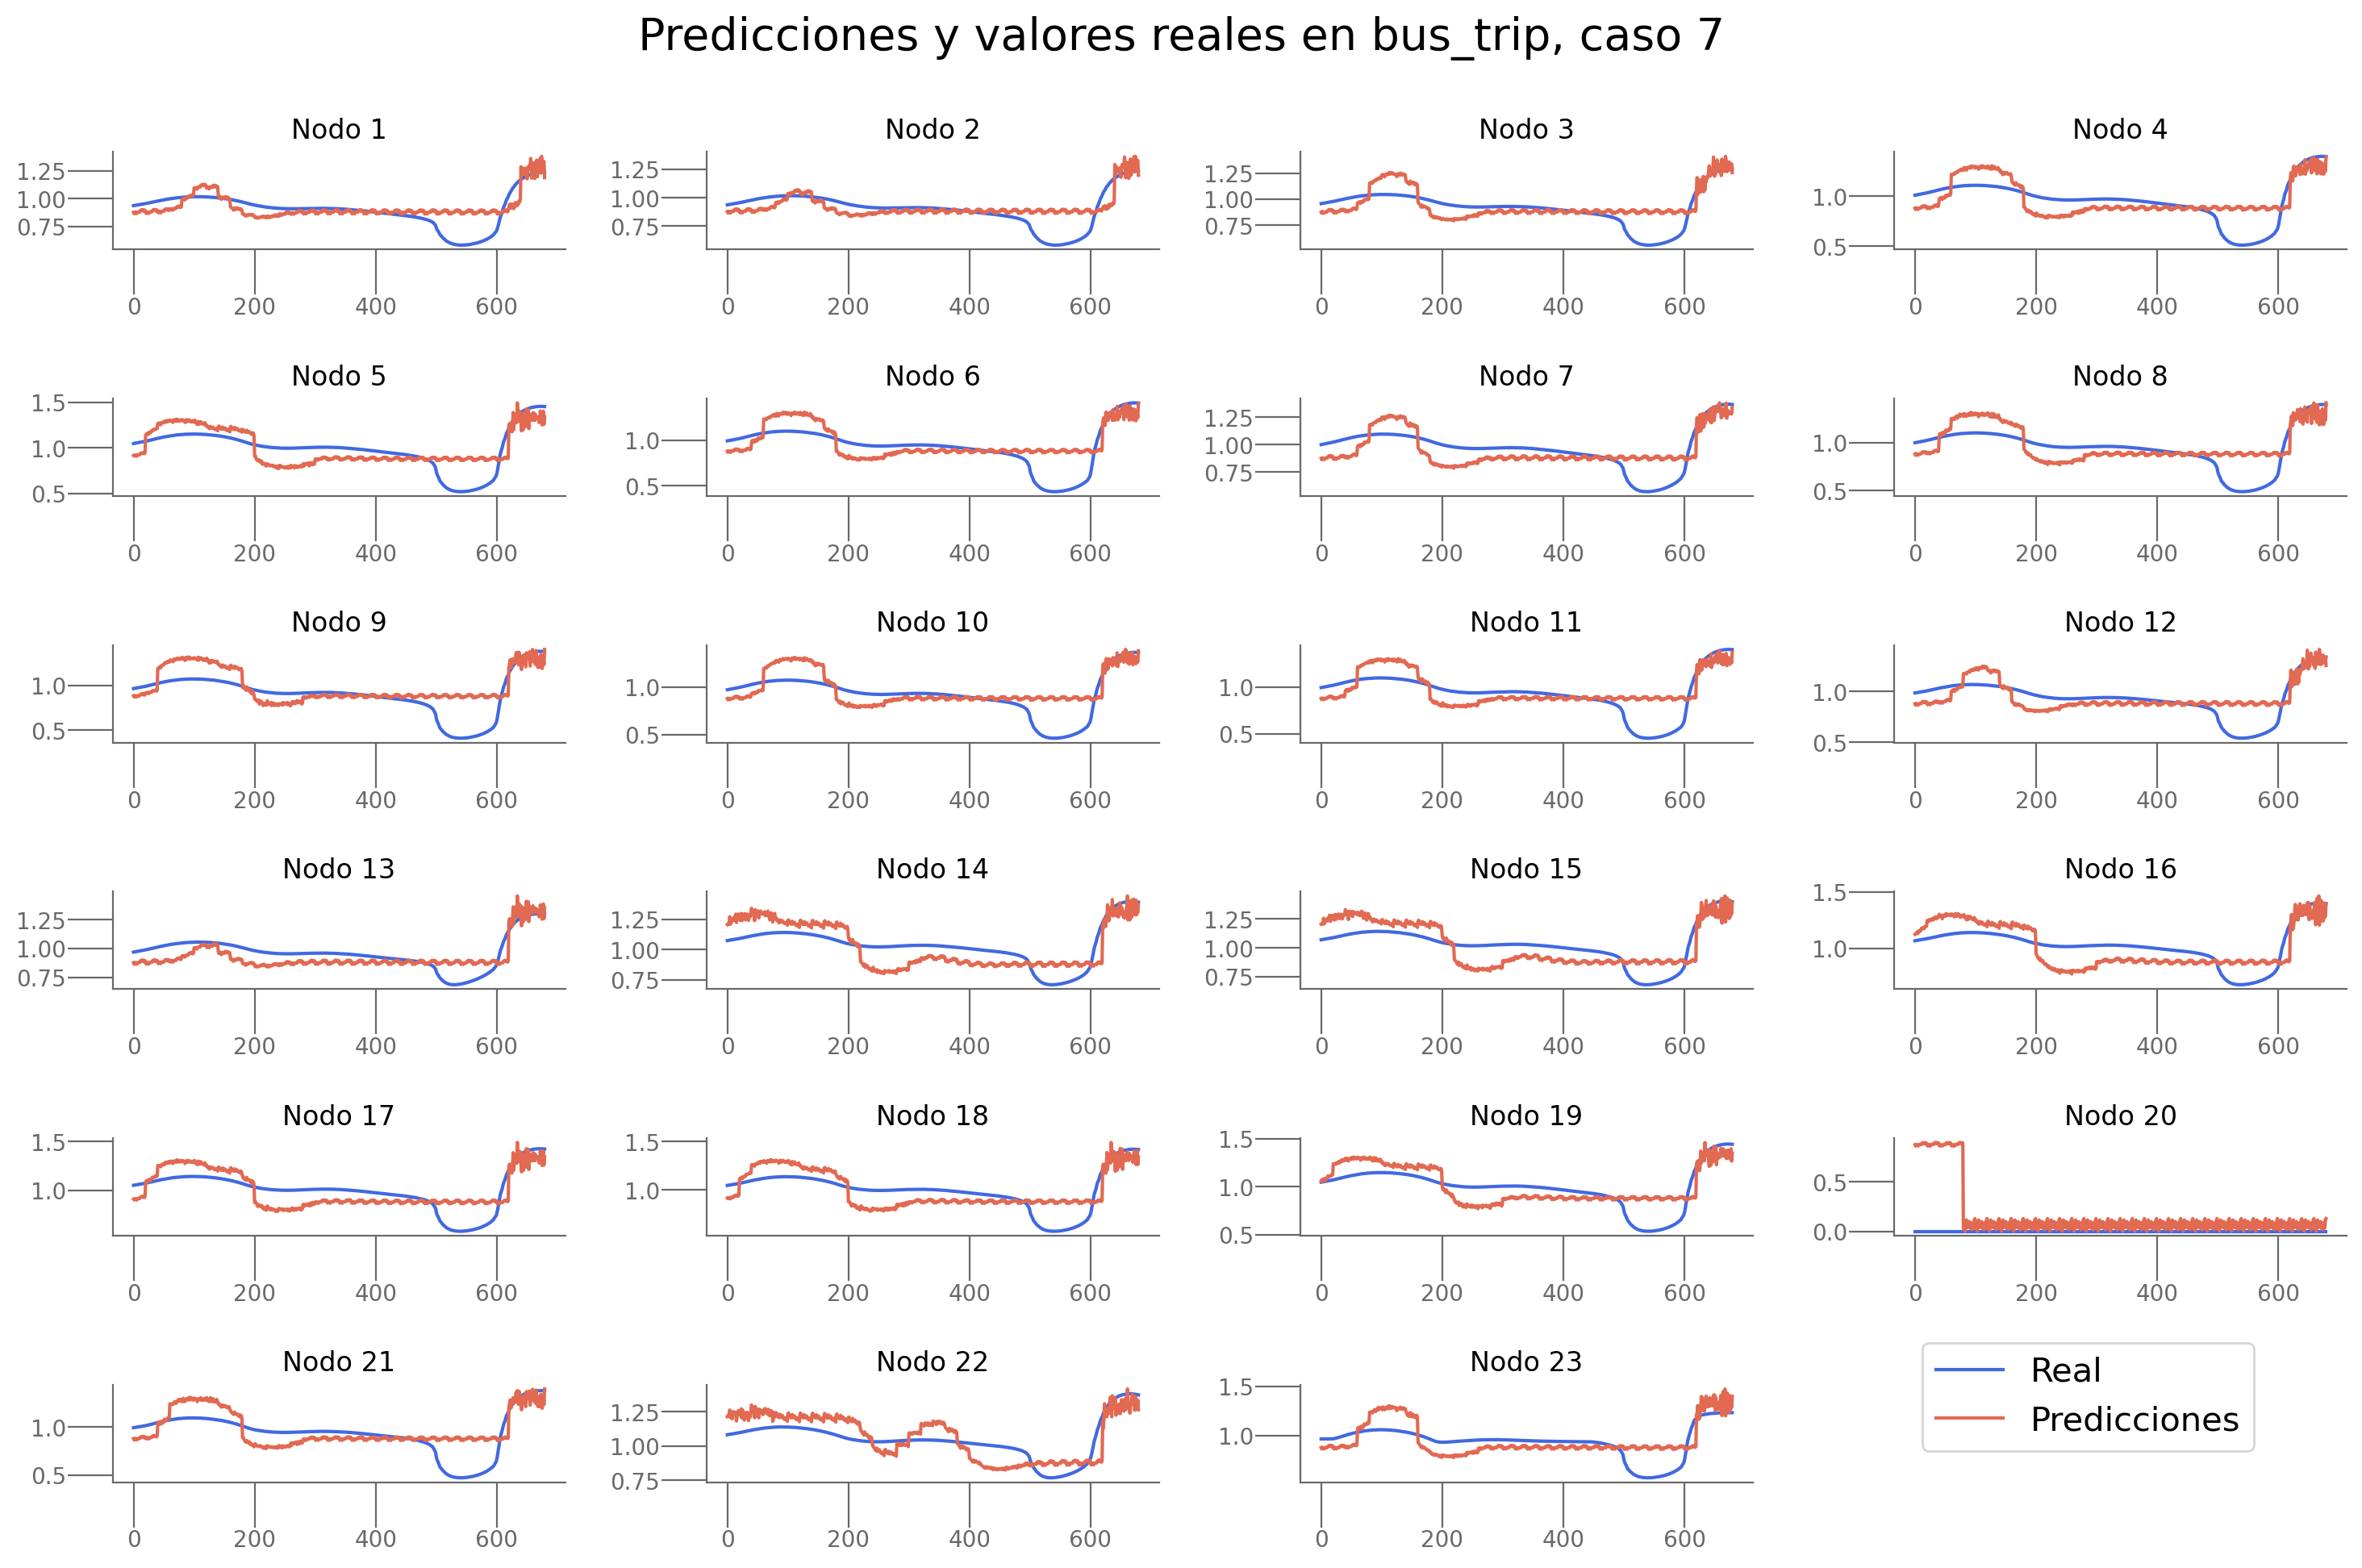

In [32]:
plot_predictions(predictions_bt, real_bt, n_target, 7, n_div_bt, problem_bt)

In [33]:
trainer_bt.save_model(params={"nb_block":1, "K":2, "nb_chev_filter" : 2, "nb_time_filter" :2, "time_strides" : 2, "hidden":50})


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1  LSTM_NOBATCH                                                NaN   
2     MPNN_LSTM                                          (32, 0.8)   
3   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 1}   
4     EvolveGCN                                                NaN   
5         AGCRN            {'hidden': 10, 'K': 10, 'embedding': 3}   
6        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
7         DCRNN                                     {'hidden': 60}   
8         MTGNN  {'gcn_depth': 1, 'conv_channels': 16, 'kernel_...   
9        ASTGCN  {'nb_block': 1, 'K': 2, 'nb_chev_filter': 2, '...   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.005474  0.923150   
1            

### Bus fault

In [26]:
problem_bf = "bus_fault"
dataset_bf, situations_bf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_bf)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [27]:
n_div_bf = loader.div
n_nodes =dataset_bf.features[0].shape[0]
n_target = dataset_bf.targets[0].shape[1]
n_features = dataset_bf[0].x.shape[1]
hidden_size =32
dropout = 0.5

num_early_stop = 0
num_epochs = 30
lr = 0.01

#### Sencilla 

In [29]:

device =  torch.device("cpu")
model_bf = ASTGCNModel(name="ASTGCN", node_features=n_features, node_count=n_nodes, n_target=n_target, nb_block=1, k=2, nb_chev_filter = 4, nb_time_filter =4, time_strides = 2, hidden_size=50)


trainer_bf = TrainerMSTGCN(model_bf, dataset_bf,device, f"./results/{problem_bf}", dataloader_params2)


losses,eval_losses, r2scores  = trainer_bf.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)





==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1561 | Eval Loss: 0.0979 | Eval R2: -11.0297 | LR: 0.0010 | 
Epoch 2/30 | Train Loss: 0.0607 | Eval Loss: 0.0666 | Eval R2: -6.7277 | LR: 0.0010 | 
Epoch 3/30 | Train Loss: 0.0460 | Eval Loss: 0.0573 | Eval R2: -5.7317 | LR: 0.0010 | 
Epoch 4/30 | Train Loss: 0.0398 | Eval Loss: 0.0509 | Eval R2: -4.9794 | LR: 0.0010 | 
Epoch 5/30 | Train Loss: 0.0354 | Eval Loss: 0.0463 | Eval R2: -4.4011 | LR: 0.0010 | 
Epoch 6/30 | Train Loss: 0.0323 | Eval Loss: 0.0430 | Eval R2: -3.9630 | LR: 0.0010 | 
Epoch 7/30 | Train Loss: 0.0301 | Eval Loss: 0.0405 | Eval R2: -3.6371 | LR: 0.0010 | 
Epoch 8/30 | Train Loss: 0.0285 | Eval Loss: 0.0388 | Eval R2: -3.3966 | LR: 0.0010 | 
Epoch 9/30 | Train Loss: 0.0273 | Eval Loss: 0.0374 | Eval R2: -3.2204 | LR: 0.0010 | 
Epoch 10/30 | Train Loss: 0.0265 | Eval Loss

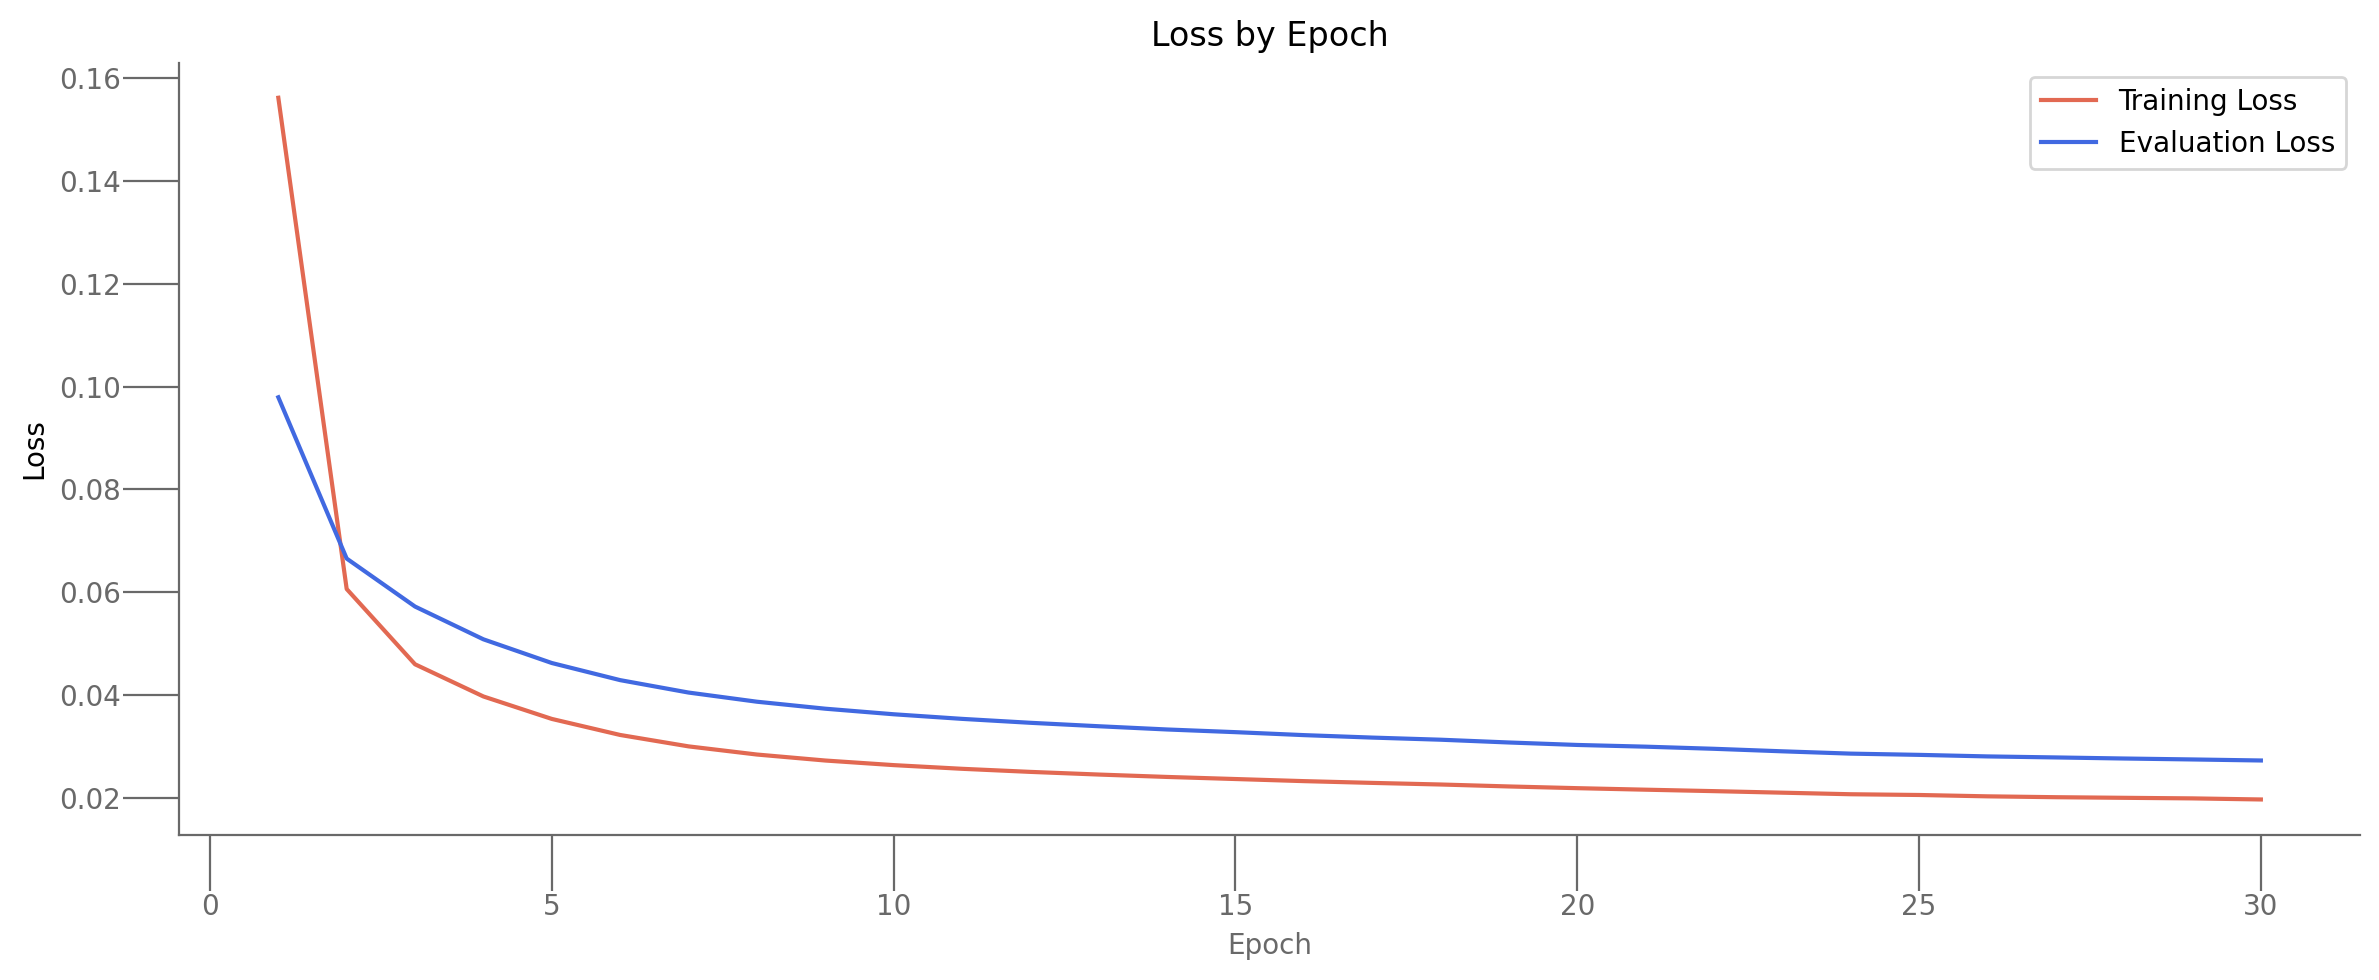


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.017267, test R2 score: -0.657352


In [30]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_bf, real_bf = trainer_bf.test()

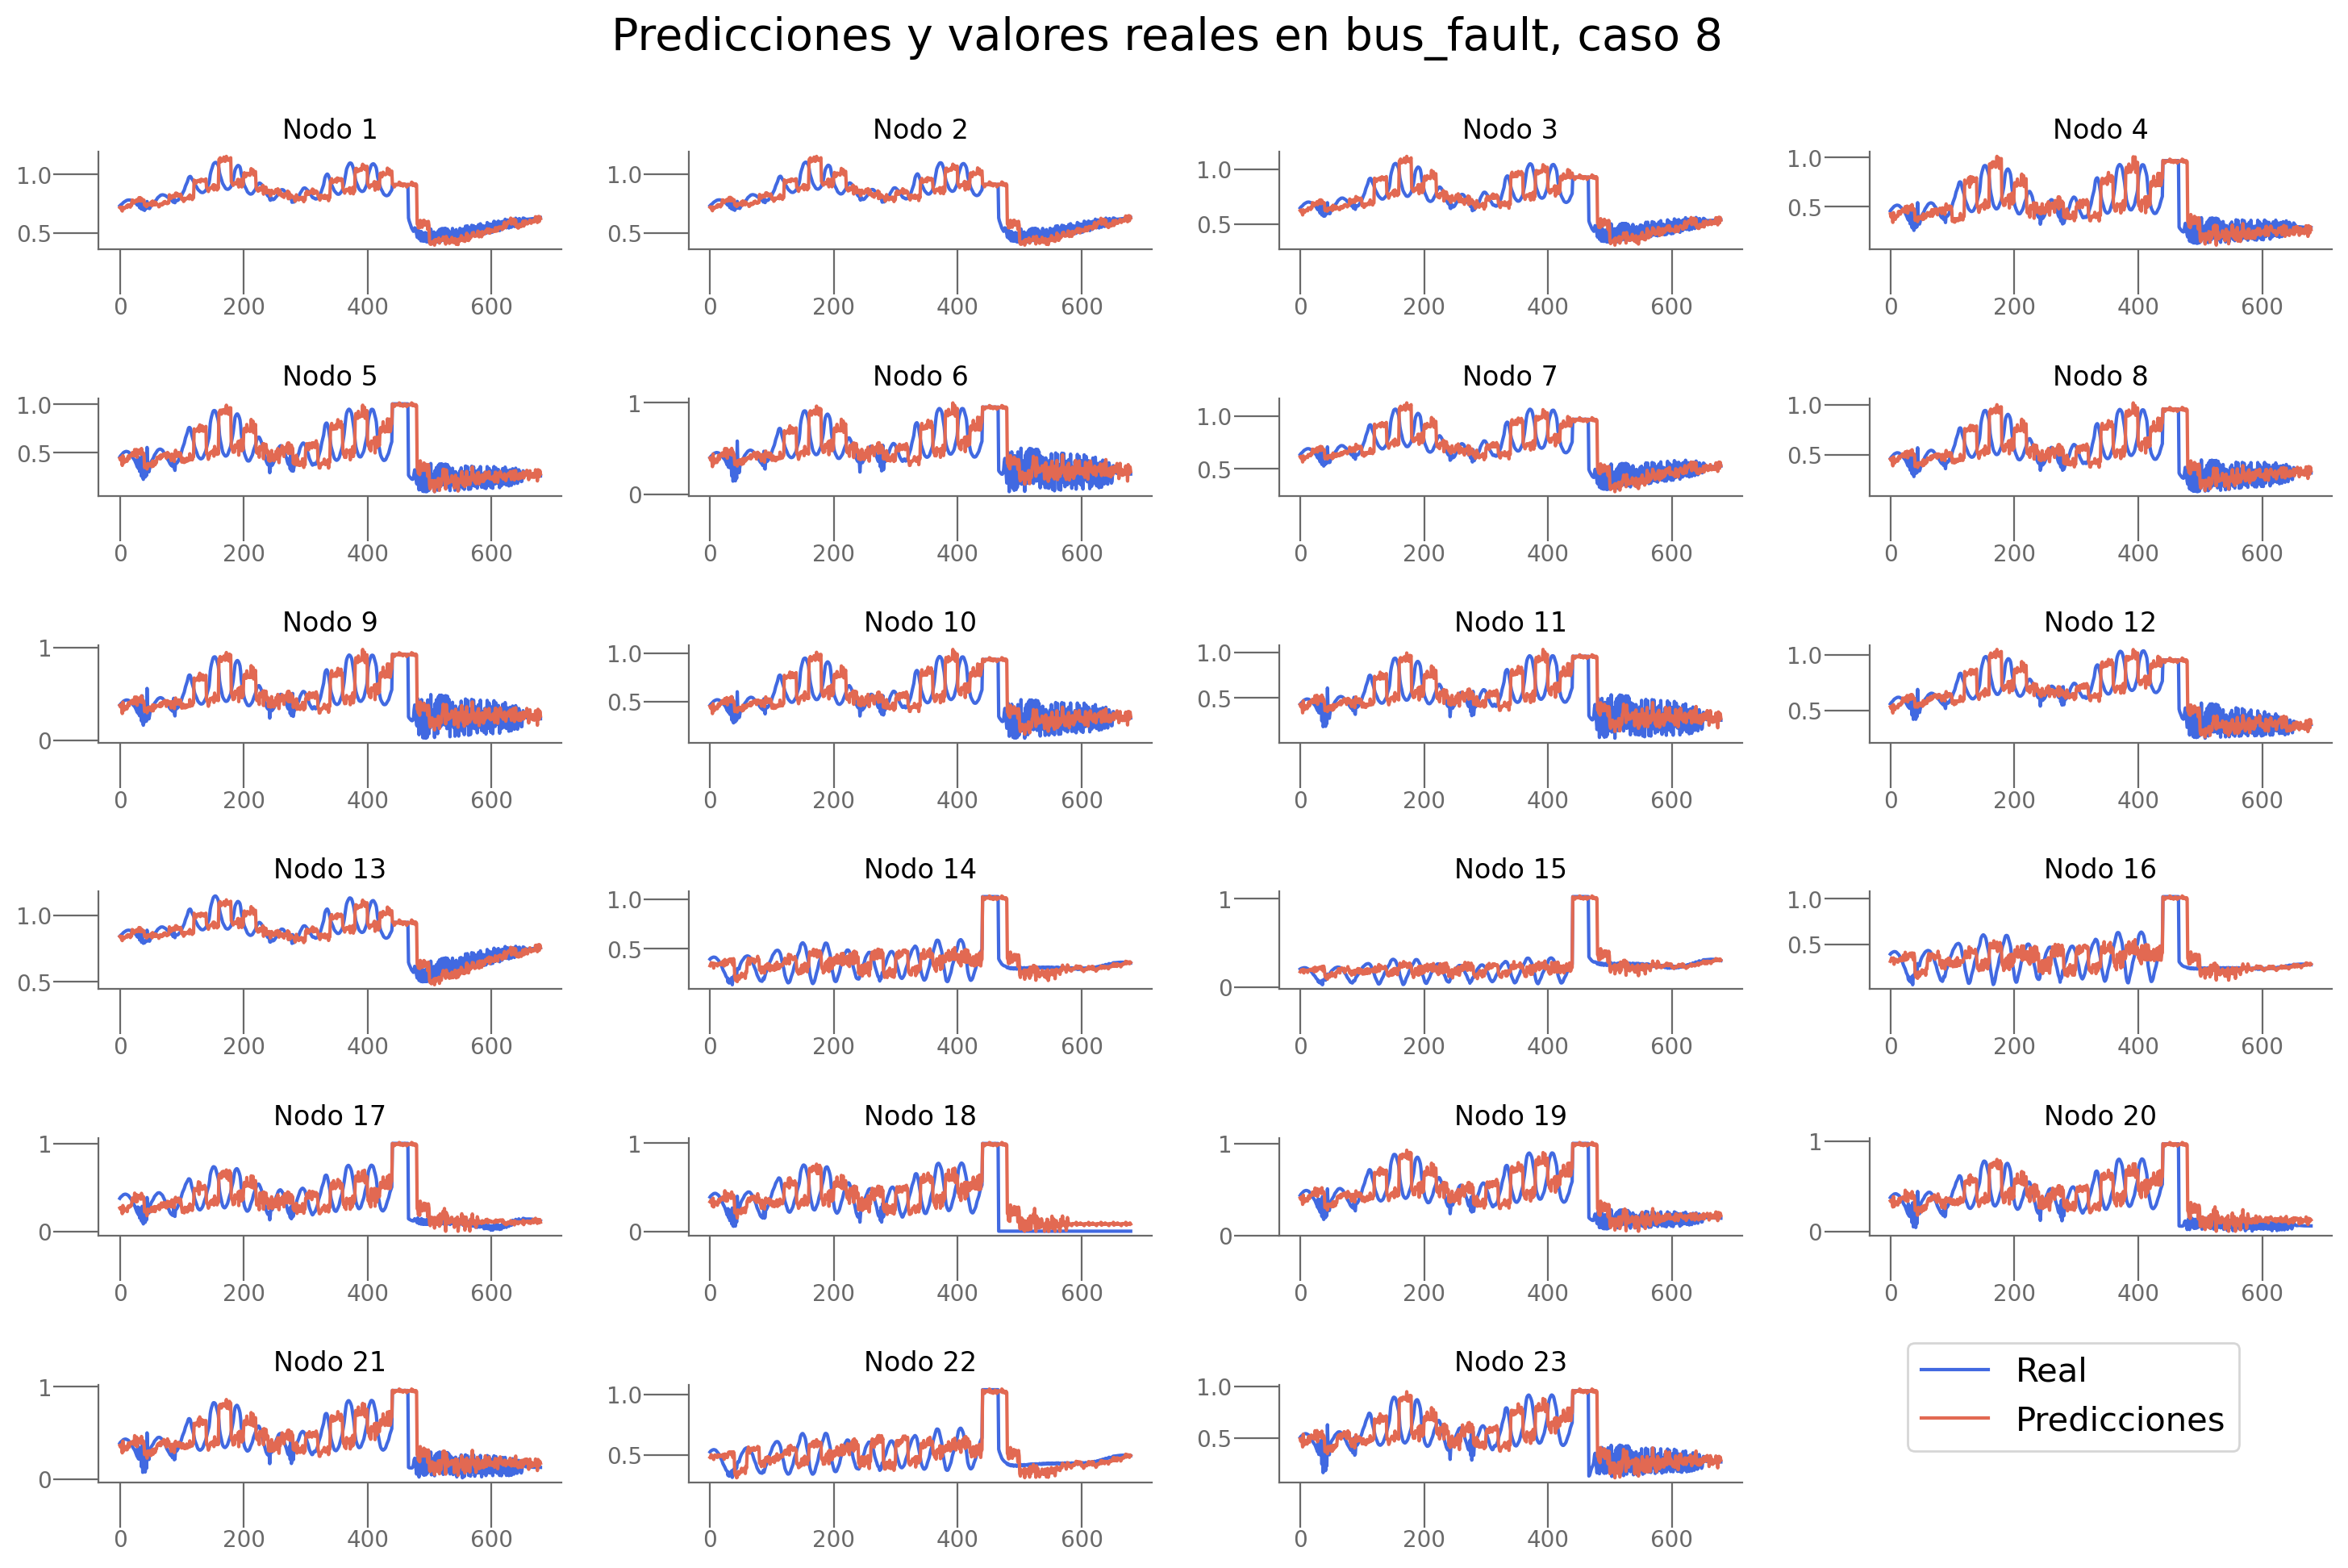

In [33]:
plot_predictions(predictions_bf, real_bf, n_target, 8, n_div_bf, problem_bf)

In [31]:
trainer_bf.save_path = f"../experimentos_split/results/{problem_bf}"

In [32]:
trainer_bf.save_model()


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1  LSTM_NOBATCH                                                NaN   
2     MPNN_LSTM                {'hidden_size': 64, 'dropout': 0.2}   
3   DyGrEncoder             {'aggr': 'mean', 'conv': 1, 'lstm': 1}   
4         DCRNN                                     {'hidden': 40}   
5        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
6     EvolveGCN                                                NaN   
7        ASTGCN                                               None   

                      Fichero_resultados_experimento  Loss_tst     R2_tst  \
0                                                NaN  0.017298   0.603716   
1                                                NaN  0.017459  -1.122112   
2   ./results/bus_fault/ajustes/MPNNLSTM_results.csv  0.016746  -0.682421 

### Branch Fault

In [34]:
problem_brf = "branch_fault"
dataset_brf, situations_brf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_brf)


Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  92


In [38]:
n_div_brf = loader.div
n_nodes =dataset_brf.features[0].shape[0]
n_target = dataset_brf.targets[0].shape[1]
n_features = dataset_brf[0].x.shape[1]
hidden_size =32
dropout = 0.5

num_early_stop = 10
num_epochs = 100
lr = 0.01

#### Sencilla 

In [40]:

device =  torch.device("cpu")
model_brf = ASTGCNModel(name="ASTGCN", node_features=n_features, node_count=n_nodes, n_target=n_target, nb_block=1, k=2, nb_chev_filter = 4, nb_time_filter =4, time_strides = 2, hidden_size=20)

trainer_brf = TrainerMSTGCN(model_brf, dataset_brf,device, f"./results/{problem_brf}", dataloader_params2)


losses,eval_losses, r2scores  = trainer_brf.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)





==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0.1498 | Eval Loss: 0.1169 | Eval R2: -11.7653 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 0.0665 | Eval Loss: 0.0743 | Eval R2: -7.0805 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 0.0507 | Eval Loss: 0.0610 | Eval R2: -5.7512 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 0.0434 | Eval Loss: 0.0530 | Eval R2: -4.9923 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 0.0389 | Eval Loss: 0.0479 | Eval R2: -4.5041 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 0.0359 | Eval Loss: 0.0444 | Eval R2: -4.1858 | LR: 0.0010 | 
Epoch 7/100 | Train Loss: 0.0339 | Eval Loss: 0.0421 | Eval R2: -3.9727 | LR: 0.0010 | 
Epoch 8/100 | Train Loss: 0.0326 | Eval Loss: 0.0405 | Eval R2: -3.8350 | LR: 0.0010 | 
Epoch 9/100 | Train Loss: 0.0316 | Eval Loss: 0.0393 | Eval R2: -3.7431 | LR: 0.0010 | 
Epoch 10/100 | Train Loss: 0.0309 |

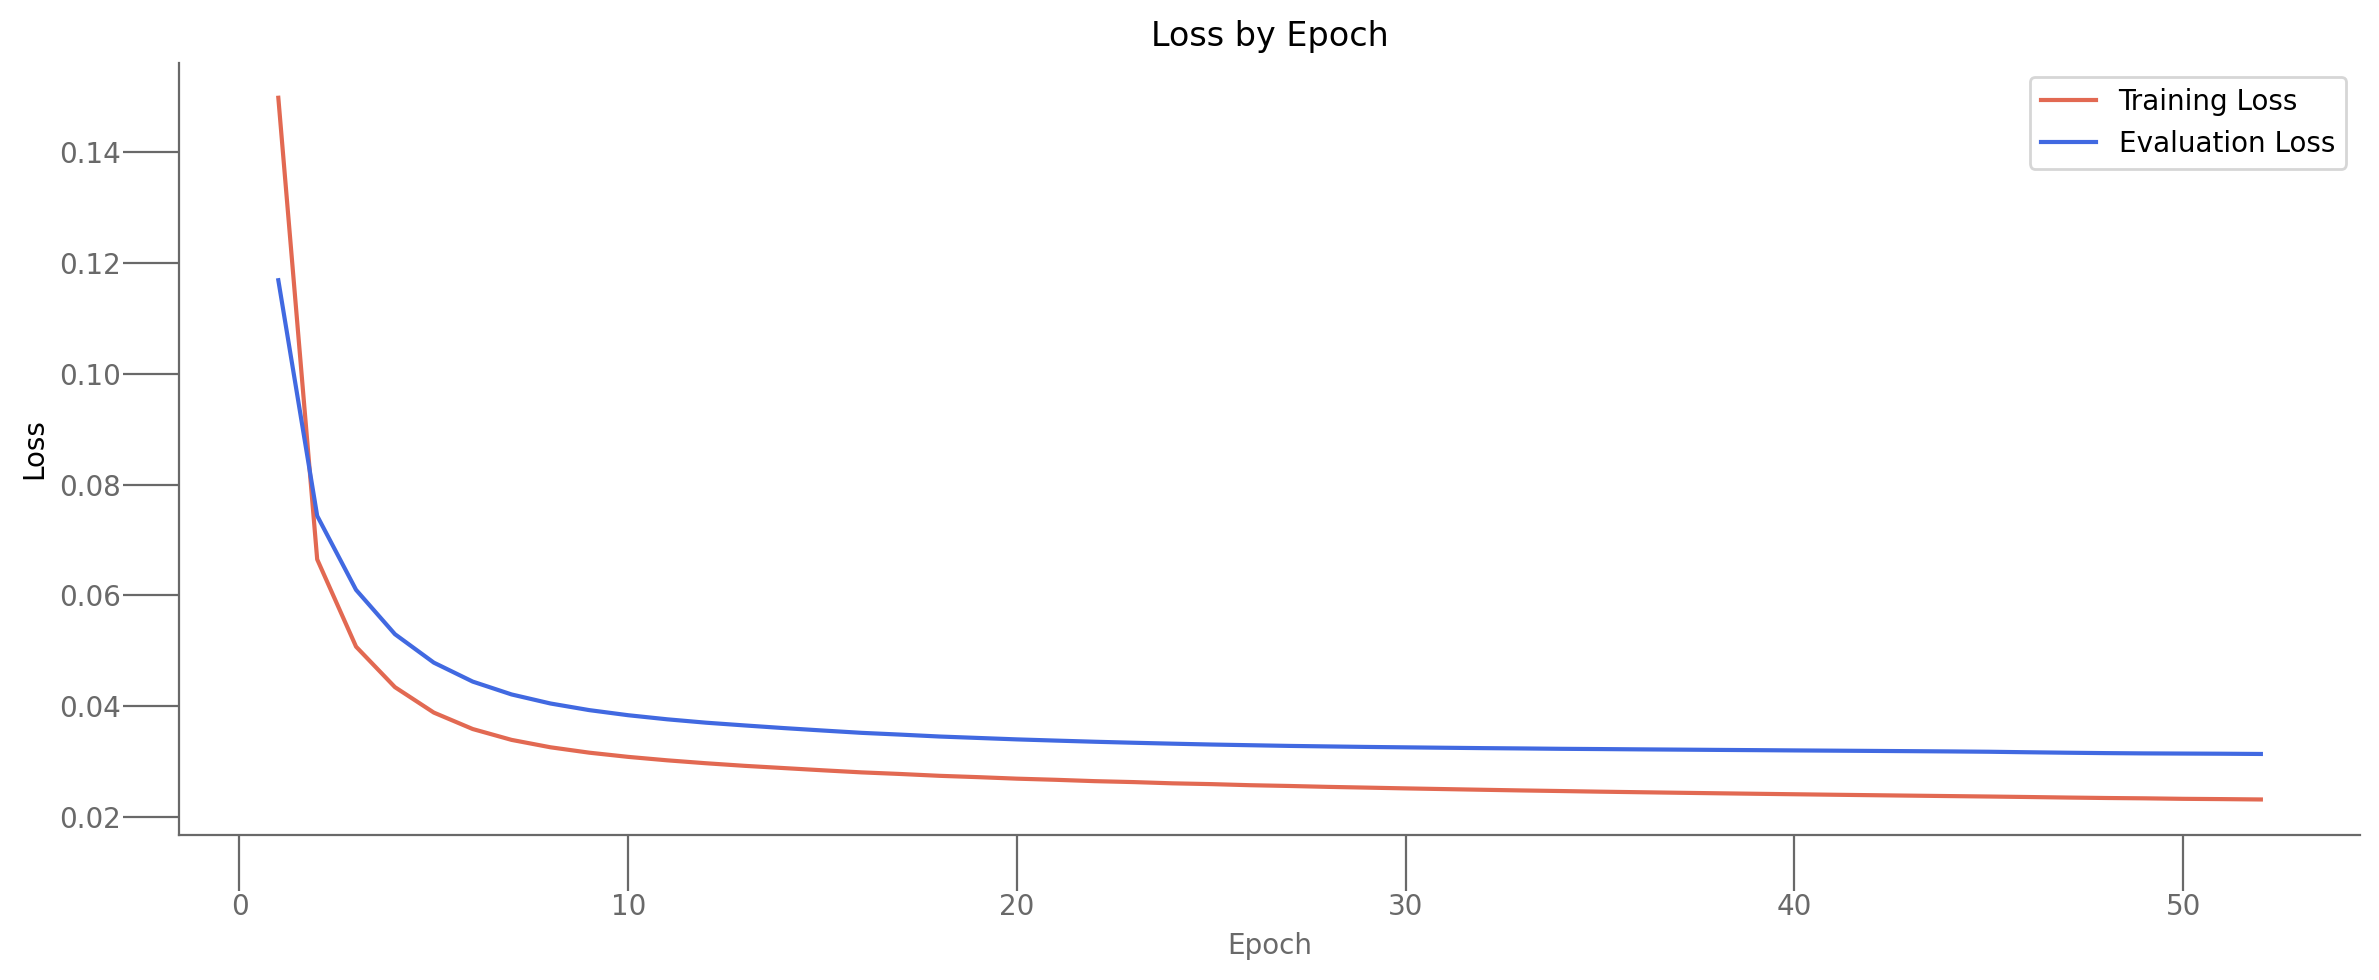


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.023290, test R2 score: -1.587091


In [42]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), len(np.array(losses)), format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_brf, real_brf = trainer_brf.test()

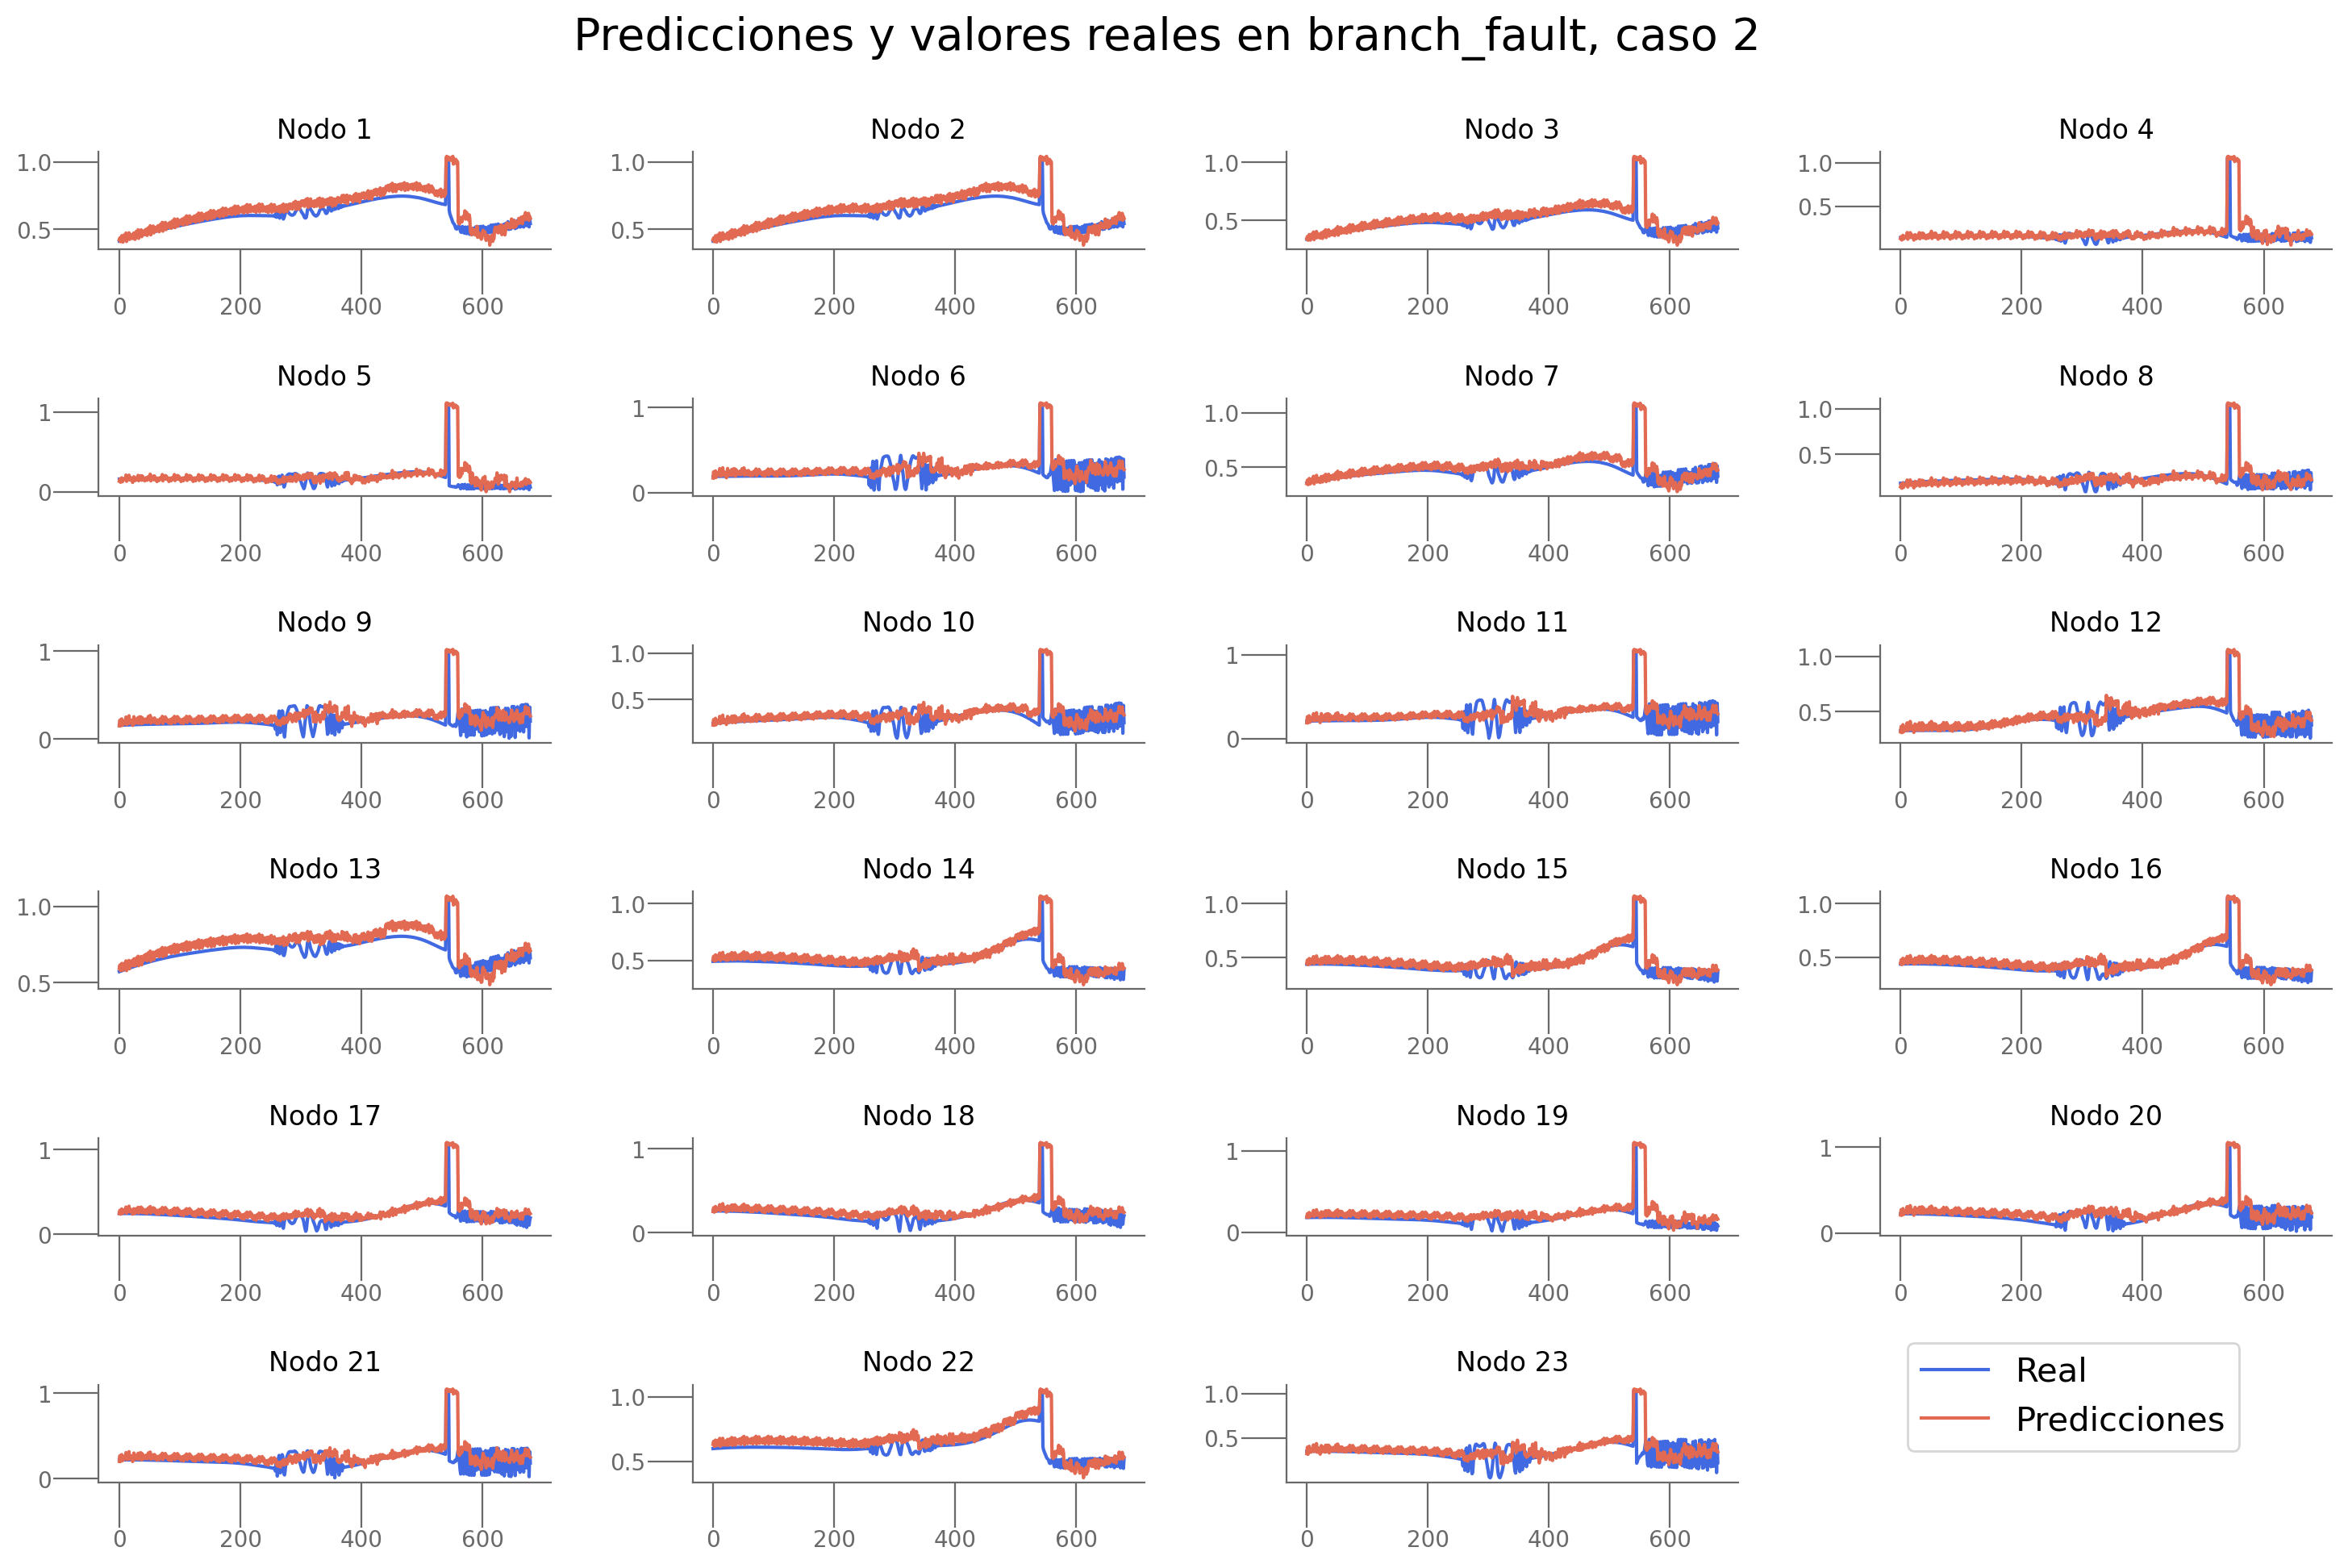

In [45]:
plot_predictions(predictions_brf, real_brf, n_target, 2, n_div_brf, problem_brf)

In [46]:
trainer_brf.save_path = f"../experimentos_split/results/{problem_brf}"

In [47]:
trainer_brf.save_model()


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1  LSTM_NOBATCH                                                NaN   
2   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 1}   
3     MPNN_LSTM                {'hidden_size': 64, 'dropout': 0.2}   
4         DCRNN                                     {'hidden': 60}   
5        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
6     EvolveGCN                                                NaN   
7        ASTGCN                                               None   

                      Fichero_resultados_experimento  Loss_tst     R2_tst  \
0                                                NaN  0.023216   0.608045   
1                                                NaN  0.021628  -1.528487   
2  ./results/branch_fault/ajustes/DryGrEncoder_re...  0.020580  -1.669938 

### Branch trip

In [48]:
problem_brt = "branch_trip"
dataset_brt, situations_brt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_brt)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  101


In [51]:
n_div_brt = loader.div
n_nodes =dataset_brt.features[0].shape[0]
n_target = dataset_brt.targets[0].shape[1]
n_features = dataset_brt[0].x.shape[1]
hidden_size =32
dropout = 0.5

num_early_stop = 10
num_epochs = 100
lr = 0.01

#### Sencilla 

In [52]:

device =  torch.device("cpu")
model_brt = ASTGCNModel(name="ASTGCN", node_features=n_features, node_count=n_nodes, n_target=n_target, nb_block=1, k=2, nb_chev_filter = 4, nb_time_filter =4, time_strides = 2, hidden_size=20)


trainer_brt = TrainerMSTGCN(model_brt, dataset_brt,device, f"./results/{problem_brt}", dataloader_params2)


losses,eval_losses, r2scores  = trainer_brt.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)





==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0.0951 | Eval Loss: 0.0345 | Eval R2: -16.9968 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 0.0245 | Eval Loss: 0.0203 | Eval R2: -9.5208 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 0.0146 | Eval Loss: 0.0128 | Eval R2: -5.8926 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 0.0100 | Eval Loss: 0.0090 | Eval R2: -4.0398 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 0.0081 | Eval Loss: 0.0077 | Eval R2: -3.4048 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 0.0074 | Eval Loss: 0.0071 | Eval R2: -3.1388 | LR: 0.0010 | 
Epoch 7/100 | Train Loss: 0.0069 | Eval Loss: 0.0067 | Eval R2: -2.9515 | LR: 0.0010 | 
Epoch 8/100 | Train Loss: 0.0066 | Eval Loss: 0.0064 | Eval R2: -2.7770 | LR: 0.0010 | 
Epoch 9/100 | Train Loss: 0.0063 | Eval Loss: 0.0061 | Eval R2: -2.6060 | LR: 0.0010 | 
Epoch 10/100 | Train Loss: 0.0060 |

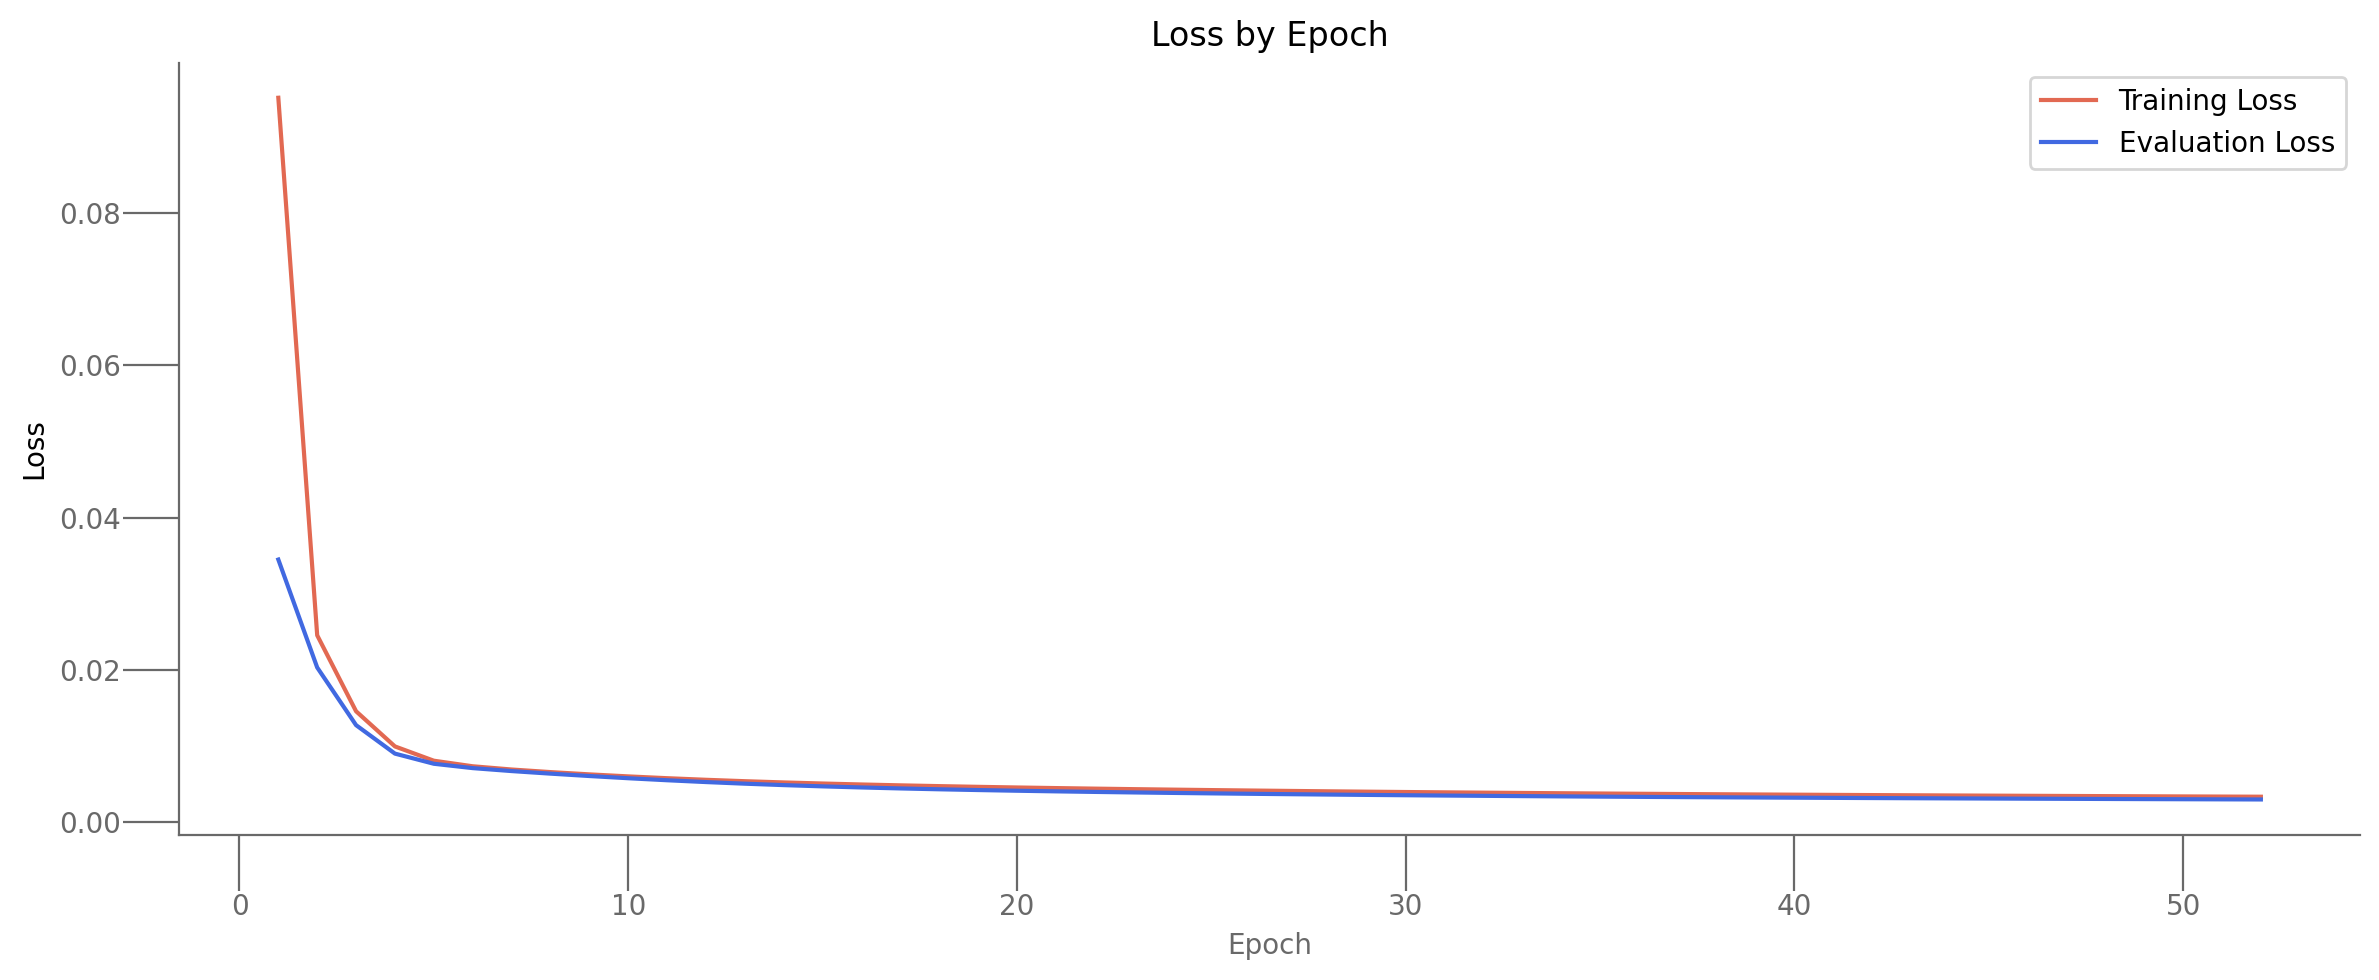


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.003289, test R2 score: -0.984139


In [54]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), len(np.array(losses)), format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_brt, real_brt = trainer_brt.test()

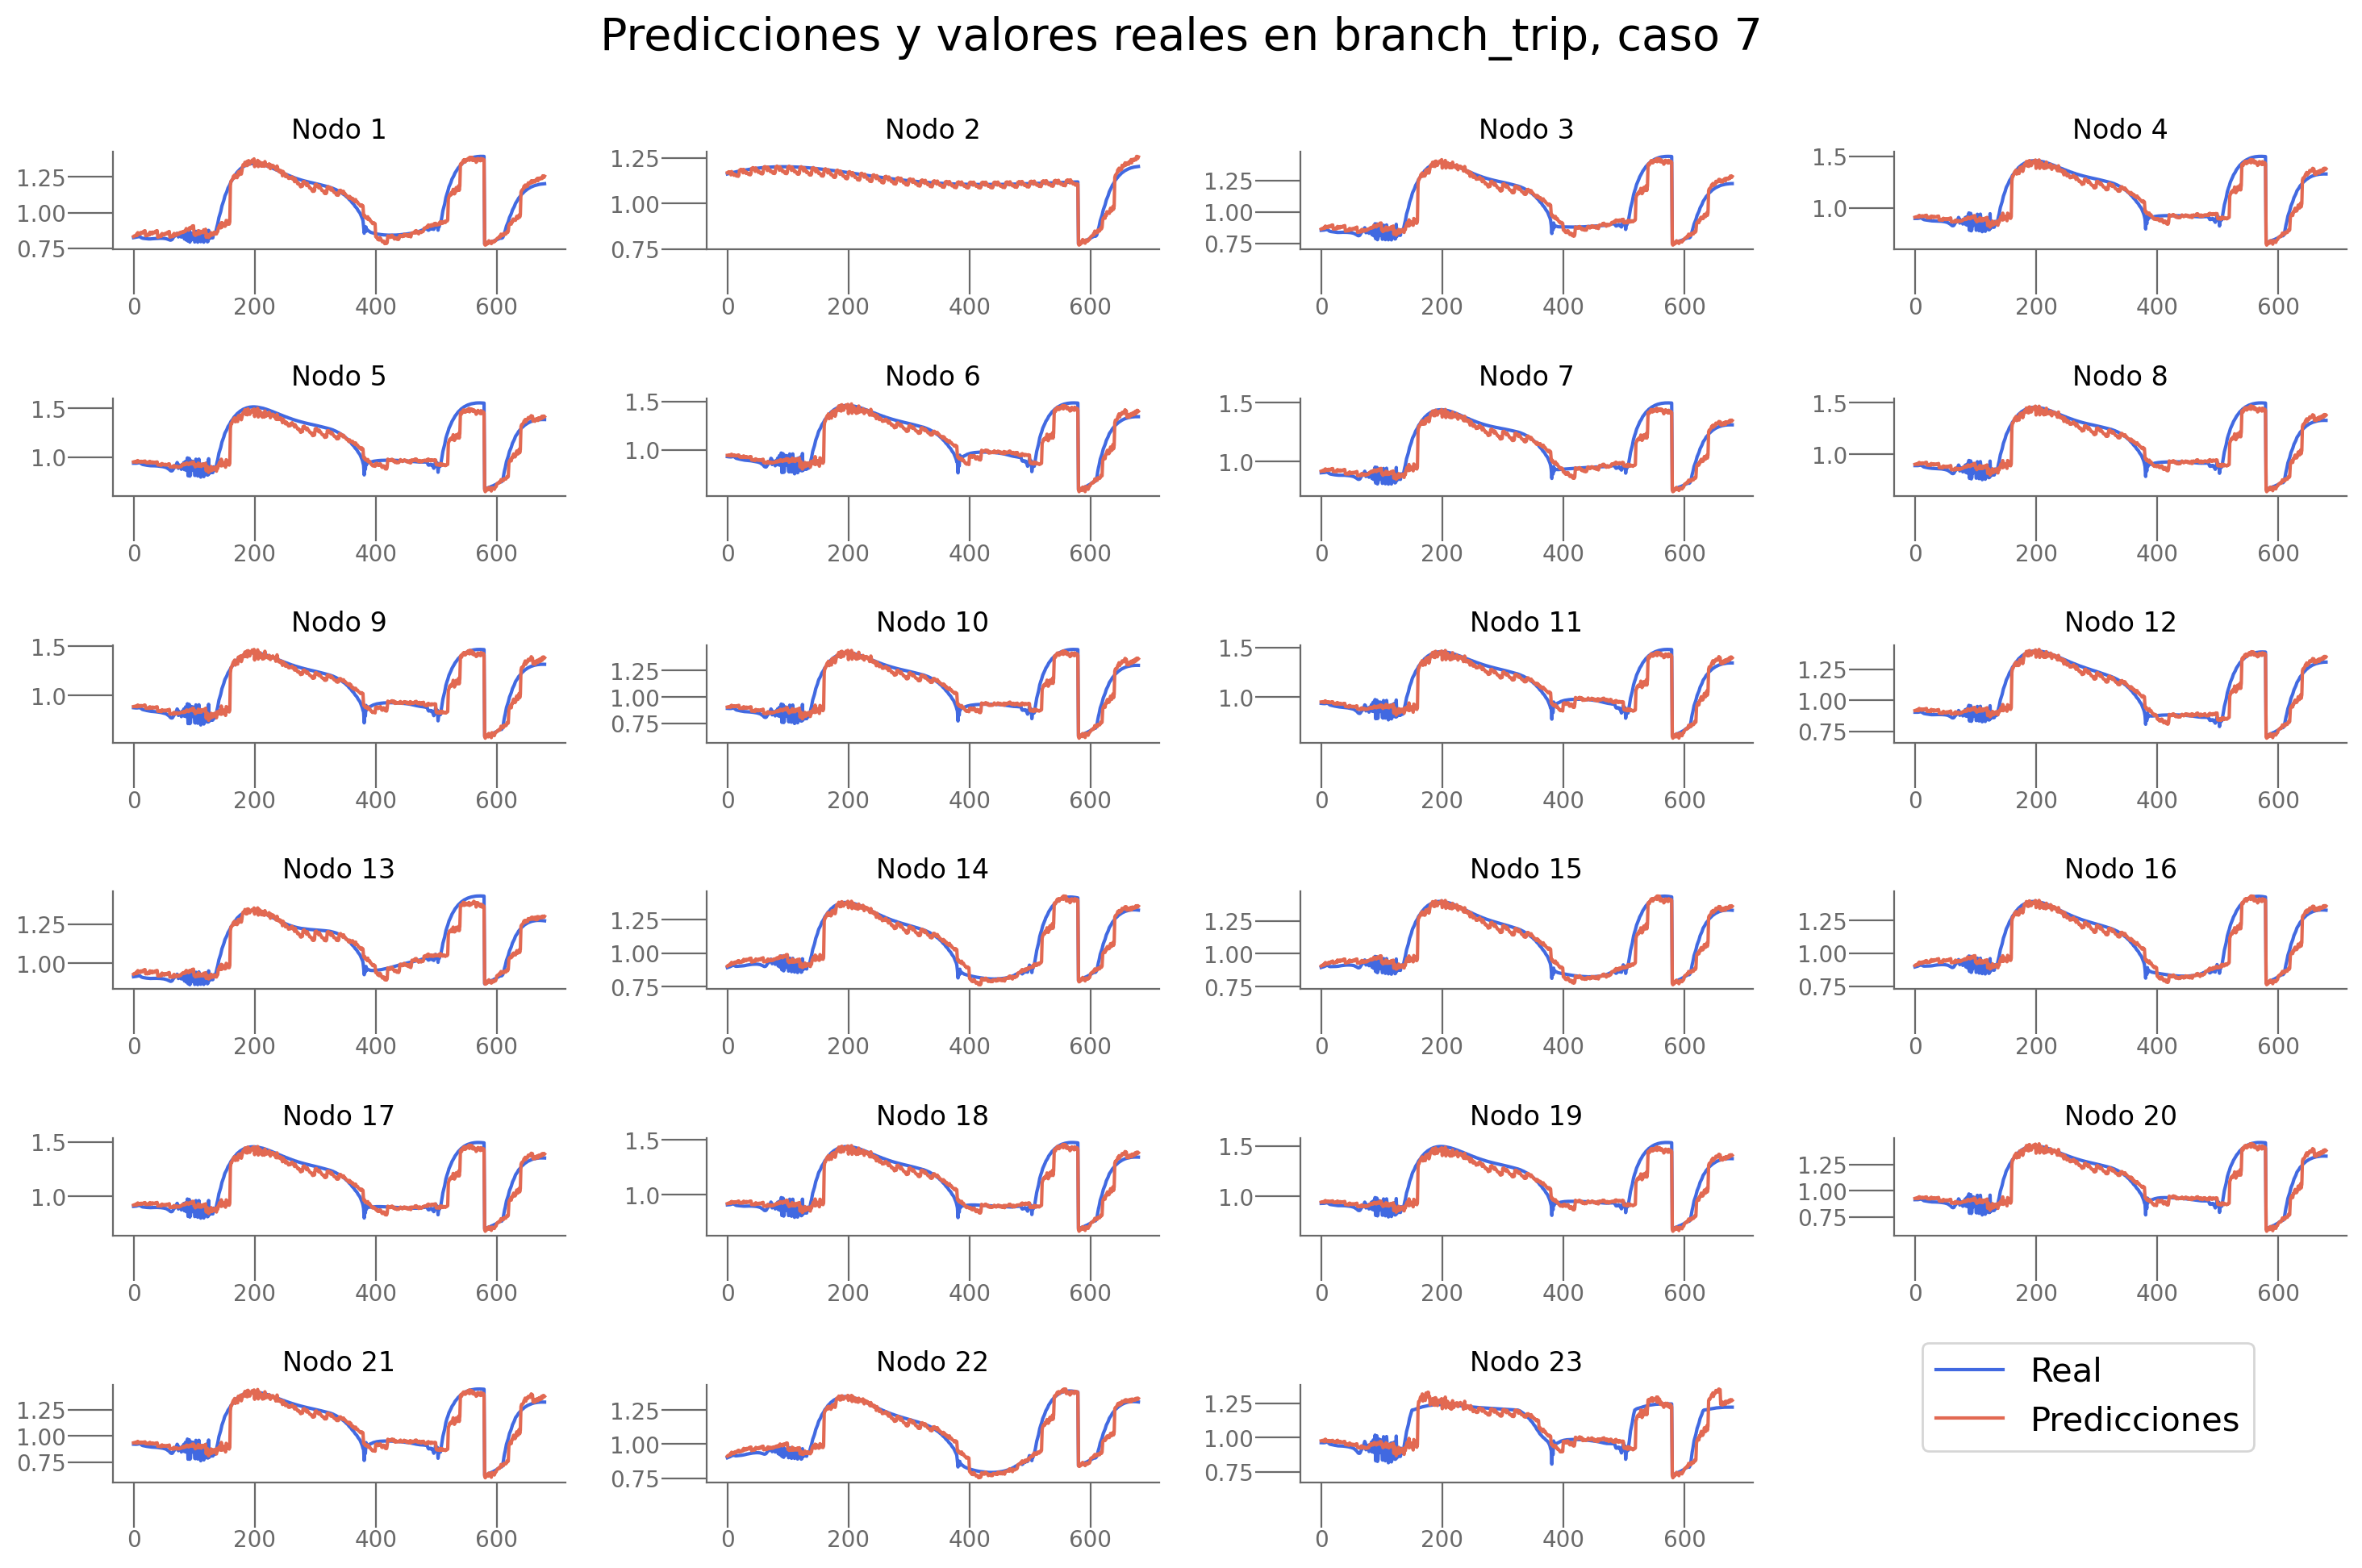

In [55]:
plot_predictions(predictions_brt, real_brt, n_target, 7, n_div_brt, problem_brt)

In [56]:
trainer_brt.save_path = f"../experimentos_split/results/{problem_brt}"

In [57]:
trainer_brt.save_model()


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1  LSTM_NOBATCH                                                NaN   
2   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 2}   
3     MPNN_LSTM                {'hidden_size': 32, 'dropout': 0.8}   
4         DCRNN                                     {'hidden': 60}   
5        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
6        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
7     EvolveGCN                                                NaN   
8        ASTGCN                                               None   

                      Fichero_resultados_experimento  Loss_tst     R2_tst  \
0                                                NaN  0.003700   0.398922   
1                                                NaN  0.004787  -1.839737   
2  .